In [1]:
import warnings

import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy as sp

from scipy.special import expit as logistic

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

In [2]:
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

def normalize(series):
    """normalize a pandas series"""
    x = series - series.min()
    return x / x.max()

## Exercise 12H1

In [3]:
df = pd.read_csv("./Data/Hurricanes.csv", sep=";")

Data used in Jung et al 2014 analysis of effect of gender of name on hurricane fatalities. Note that hurricanes Katrina (2005) and Audrey (1957) were removed from the data.

Format

    - name : Given name of hurricane

    - year : Year of hurricane

    - deaths : number of deaths

    - category : Severity code for storm

    - min_pressure : Minimum pressure, a measure of storm strength; low is stronger

    - damage_norm : Normalized estimate of damage in dollars

    - female : Indicator variable for female name

    - femininity : 1-11 scale from totally masculine (1) to totally feminine (11) for name. Average of 9 scores from 9 raters.


In [4]:
df

name  year  deaths  category  min_pressure  damage_norm  female  \
0       Easy  1950       2         3           960         1590       1   
1       King  1950       4         3           955         5350       0   
2       Able  1952       3         1           985          150       0   
3    Barbara  1953       1         1           987           58       1   
4   Florence  1953       0         1           985           15       1   
..       ...   ...     ...       ...           ...          ...     ...   
87    Gustav  2008      52         2           954         4360       0   
88       Ike  2008      84         2           950        20370       0   
89     Irene  2011      41         1           952         7110       1   
90     Isaac  2012       5         1           966        24000       0   
91     Sandy  2012     159         2           942        75000       1   

    femininity  
0      6.77778  
1      1.38889  
2      3.83333  
3      9.83333  
4      8.33333  
..         ...  
87     1.72222  
88     1.88889  
89     9.27778  
90     1.94444  
91     9.00000  

[92 rows x 8 columns]

In [5]:
df.describe().round(2)

year  deaths  category  min_pressure  damage_norm  female  \
count    92.00   92.00     92.00         92.00        92.00   92.00   
mean   1982.09   20.65      2.09        964.91      7269.78    0.67   
std      18.77   40.90      1.06         19.07     12934.09    0.47   
min    1950.00    0.00      1.00        909.00         1.00    0.00   
25%    1964.75    2.00      1.00        950.00       245.00    0.00   
50%    1985.00    5.00      2.00        964.00      1650.00    1.00   
75%    1999.00   20.25      3.00        982.25      8162.50    1.00   
max    2012.00  256.00      5.00       1003.00     75000.00    1.00   

       femininity  
count       92.00  
mean         6.78  
std          3.23  
min          1.06  
25%          2.67  
50%          8.50  
75%          9.39  
max         10.44

In [6]:
df["femininity_norm"] = normalize( df["femininity"] )

<Axes: xlabel='femininity_norm', ylabel='deaths'>

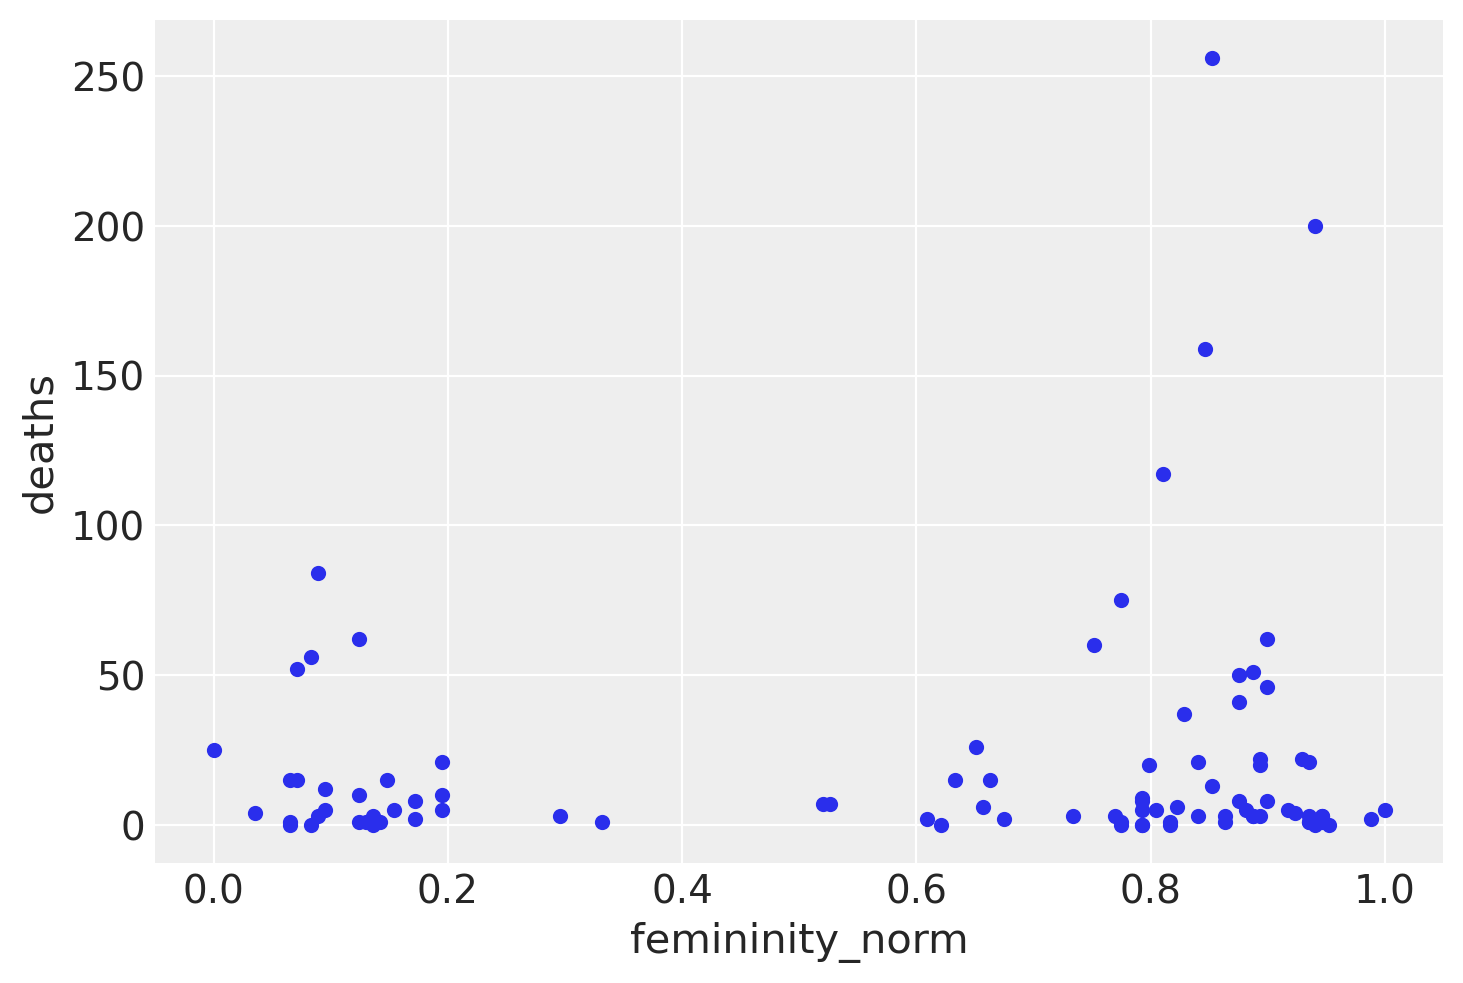

In [7]:
df.plot.scatter("femininity_norm","deaths")

Poisson model of deaths observed with femininity as predictor

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.
/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/arviz/stats/stats.py:1036: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


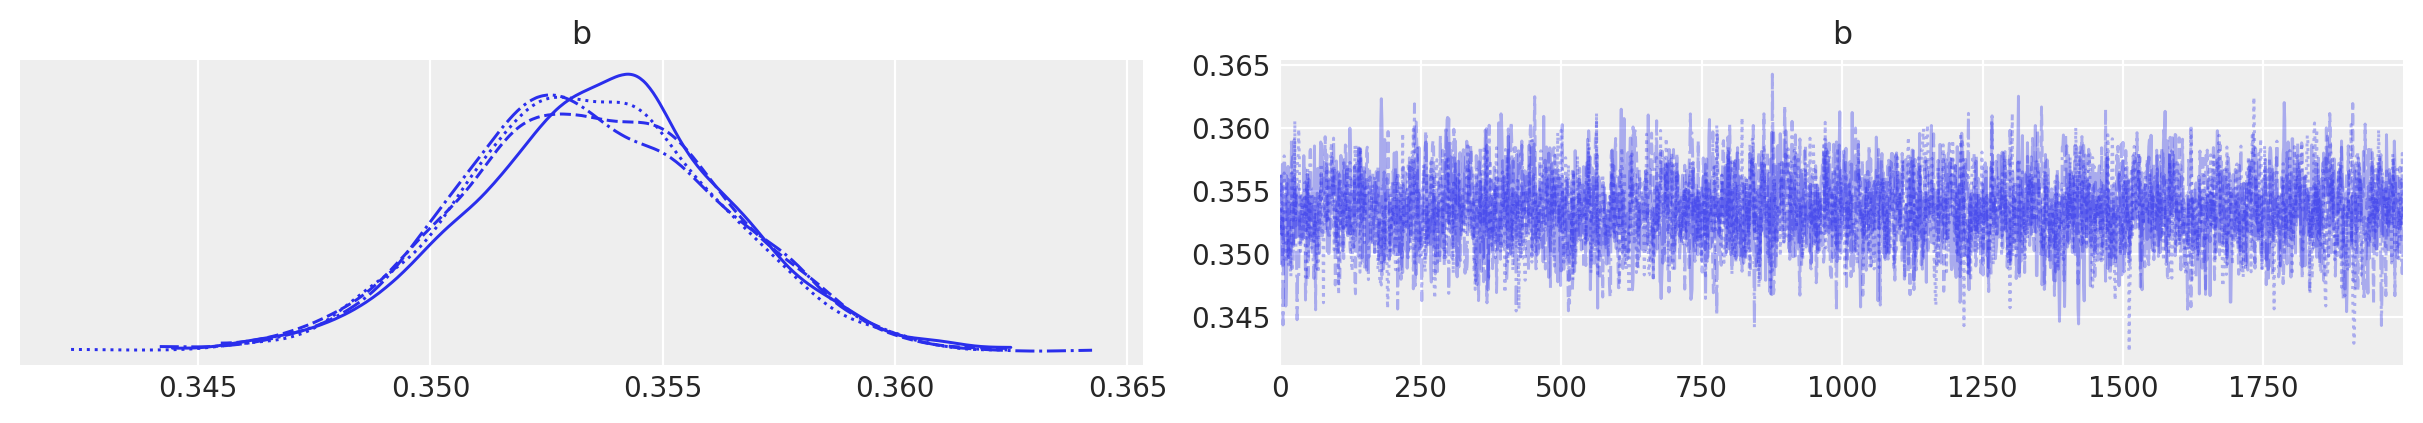

In [8]:
with pm.Model() as mh1_1:
    #a = pm.Lognormal("a", 50, 25, shape=1)
    #b = pm.Exponential("b", 0.5, shape=1)
    b = pm.Normal("b", 5, 1, shape=1)
    
    F = pm.MutableData("F",value=df.femininity)
    
    lam = at.exp( b * F )

    T = pm.Poisson("deaths", lam, observed=df.deaths)

    trace_mh1_1 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)

# store pareto-k values for plot:
k_mh1_1 = az.loo(trace_mh1_1, pointwise=True).pareto_k.values

az.plot_trace(trace_mh1_1, compact=True);

The Poisson model has a lot of influential points where there are few cases of many deaths among very feminine names

<Axes: xlabel='femininity', ylabel='deaths'>

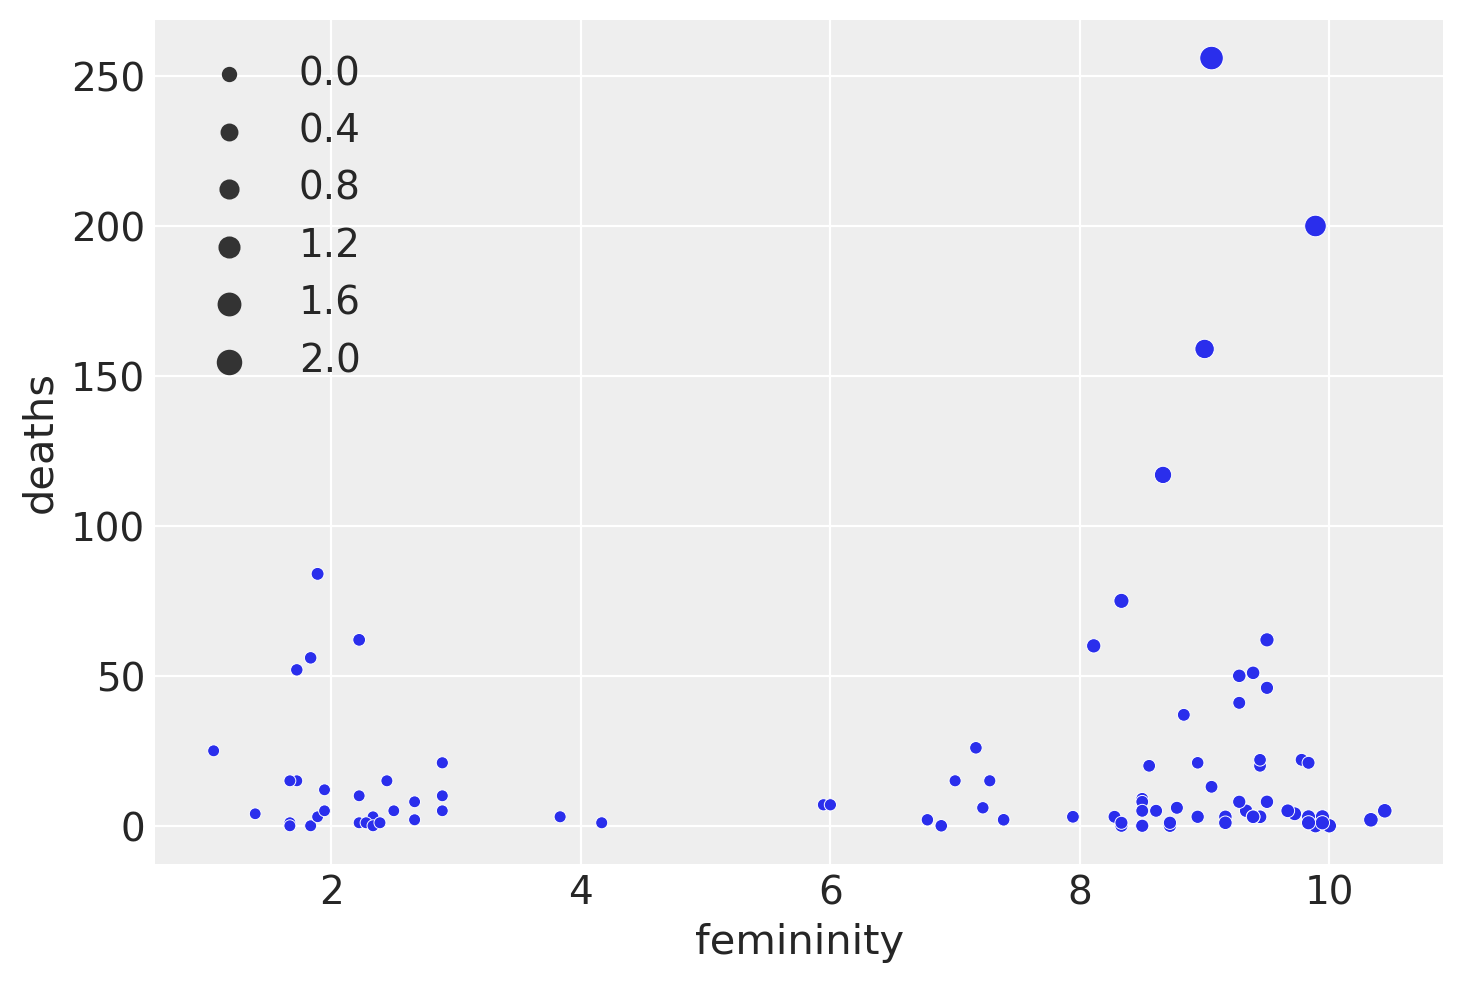

In [9]:
import seaborn as sns
sns.scatterplot(x=df.femininity, y=df.deaths, size=k_mh1_1 )

Pure intercept model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.
/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


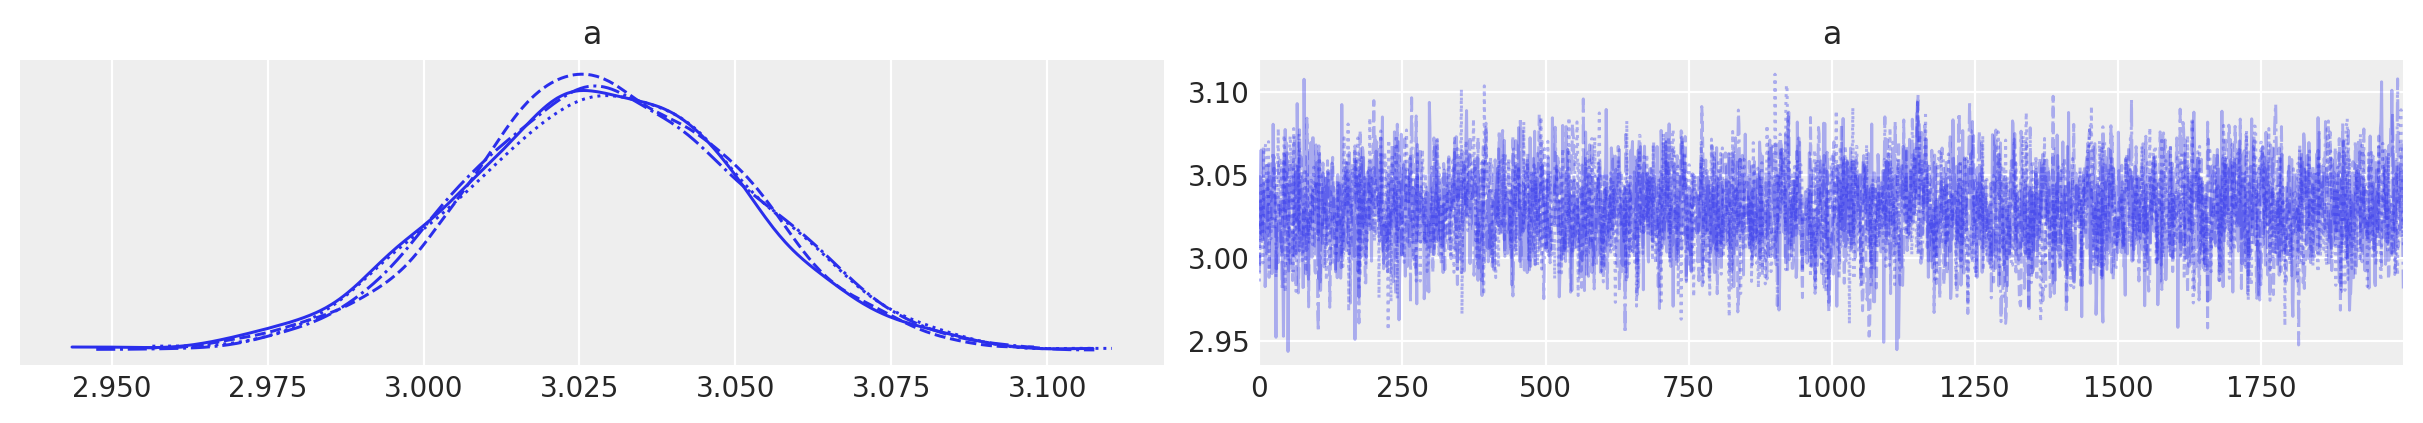

In [10]:
with pm.Model() as mh1_2:
    a = pm.Normal("a", 5, 1, shape=1)
    
    lam = at.exp(a)
    
    T = pm.Poisson("deaths", lam, observed=df.deaths)

    trace_mh1_2 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)

# store pareto-k values for plot:
k_mh1_2 = az.loo(trace_mh1_2, pointwise=True).pareto_k.values

az.plot_trace(trace_mh1_2, compact=True);

Same problem as before when looking at pareto values

<Axes: xlabel='femininity', ylabel='deaths'>

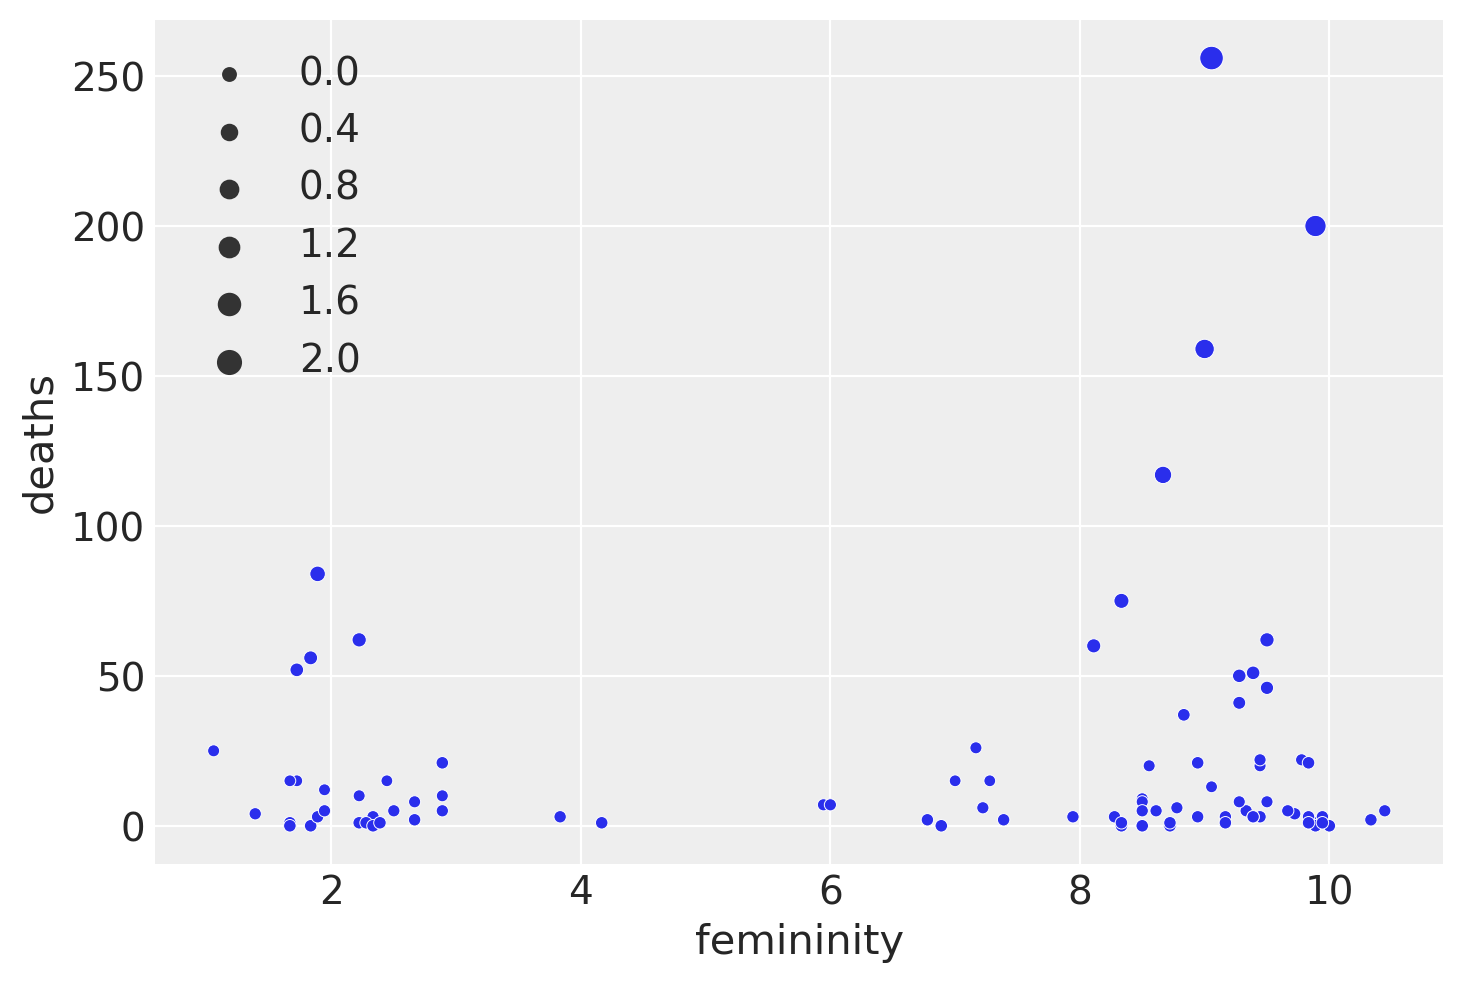

In [11]:
import seaborn as sns
sns.scatterplot(x=df.femininity, y=df.deaths, size=k_mh1_2 )

Below we can see that in the Poisson model, the intercept has a large contribution as offset for the poisson parameter. The parameter b for the predictor can add, with the highest femininity, an increase of around 20 to the parameter lambda. In the intercept-only model we are able to see how the intercept increases its value, and it can describe lambdas not much differently than the Poisson model. 

In [12]:
az.summary(trace_mh1_1, var_names=["b"], round_to=2)

mean   sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
b[0]  0.35  0.0      0.35       0.36        0.0      0.0   3085.67   4526.45   

      r_hat  
b[0]    1.0

In [13]:
az.summary(trace_mh1_2, var_names=["a"], round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a[0]  3.03  0.02      2.99       3.06        0.0      0.0   3265.69   4738.16   

      r_hat  
a[0]    1.0

Here we can verify that using the Poisson model adds very little. Weights are much worse and in favour of the intercept-only parametrization, because the Poisson model has more parametrical freedom than the intercept-only model, though the fit is poor due to the variance constraint.

In [14]:
az.compare({"Poisson": trace_mh1_1, "Intercept only": trace_mh1_2})

/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/arviz/stats/stats.py:1036: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape para

rank     elpd_loo      p_loo   elpd_diff    weight  \
Intercept only     0 -2217.701600  73.978617    0.000000  0.531983   
Poisson            1 -2653.725614  85.296660  436.024014  0.468017   

                        se         dse  warning scale  
Intercept only  532.566895    0.000000     True   log  
Poisson         546.627900  294.687379     True   log

As a last thing we can see the Intercept-only model has in general (slighty) lower pareto K values, meaning likely less overfitting of part of the data

Text(0.5, 1.0, 'Values of pareto Ks')

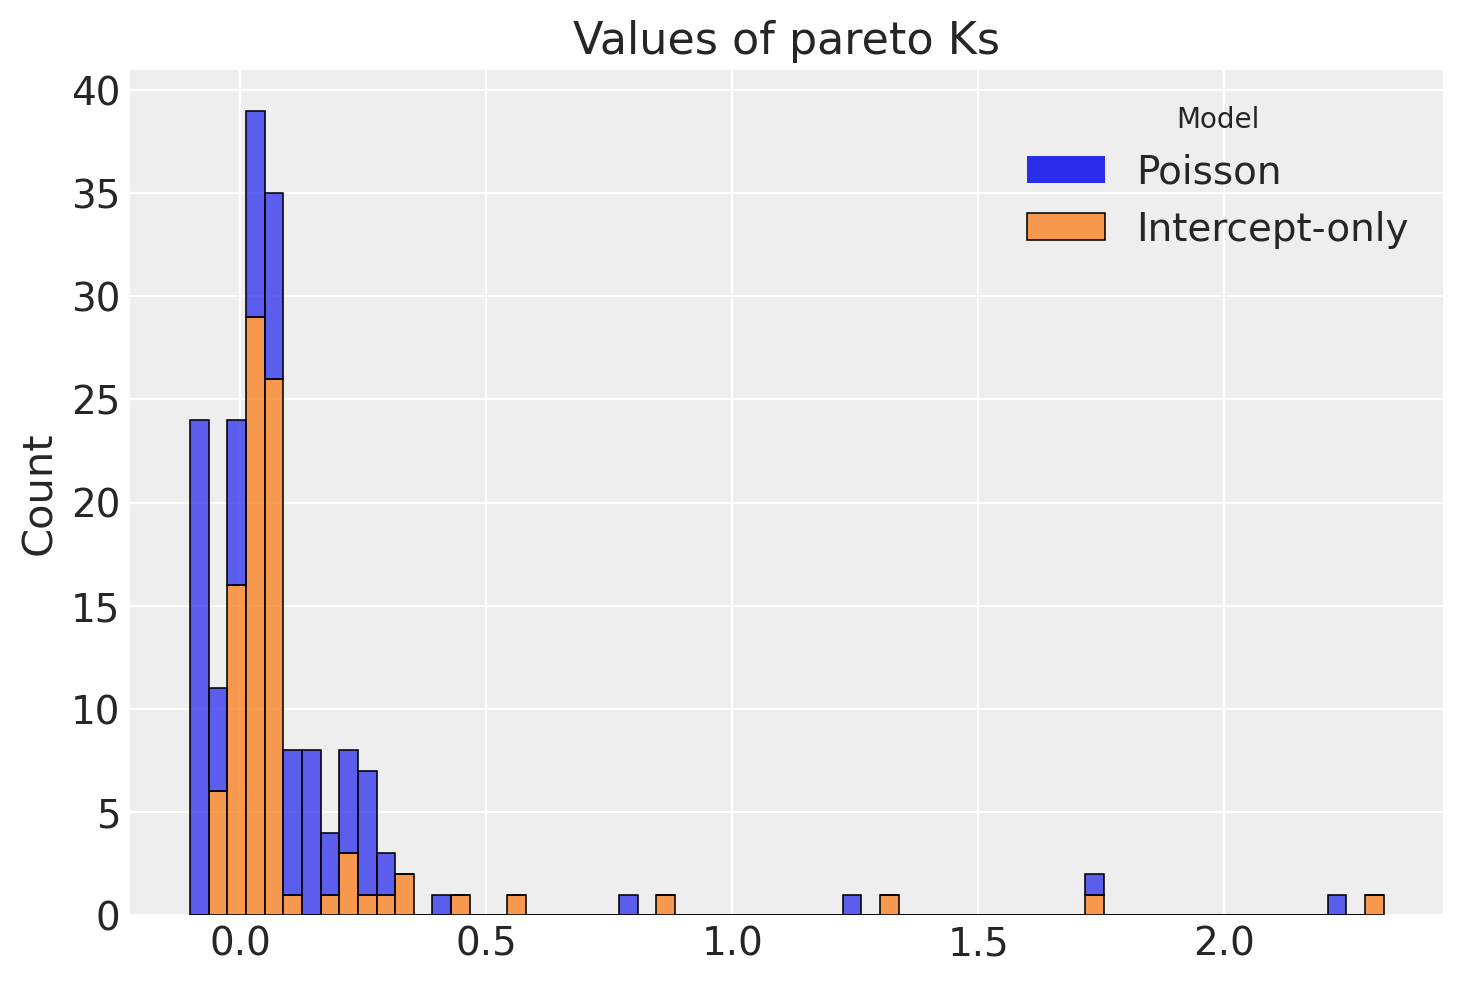

In [15]:
ax = sns.histplot( [k_mh1_1, k_mh1_2], multiple="stack" )
ax.legend(title='Model', loc='upper right', labels=['Poisson', 'Intercept-only'])
ax.set_title('Values of pareto Ks')

Retrodiction of Poisson and Intercept-Only models. It is immediate to see how both models fit the lower range of deaths, while higher values are far away from the confidence interval. Note that the Poisson model has better retrodiction on very low values of deaths, but fails just as bad on high values.

In [16]:
with mh1_1:
    retro_mh1_1 = pm.sample_posterior_predictive(trace_mh1_1, var_names=["deaths"])[
        "posterior_predictive"]["deaths"]

Sampling: [deaths]


In [17]:
with mh1_2:
    retro_mh1_2 = pm.sample_posterior_predictive(trace_mh1_2, var_names=["deaths"])[
        "posterior_predictive"]["deaths"]

Sampling: [deaths]


In [18]:
df.head()

name  year  deaths  category  min_pressure  damage_norm  female  \
0      Easy  1950       2         3           960         1590       1   
1      King  1950       4         3           955         5350       0   
2      Able  1952       3         1           985          150       0   
3   Barbara  1953       1         1           987           58       1   
4  Florence  1953       0         1           985           15       1   

   femininity  femininity_norm  
0     6.77778         0.609468  
1     1.38889         0.035503  
2     3.83333         0.295857  
3     9.83333         0.934911  
4     8.33333         0.775148

Text(0.5, 1.0, 'Retrodiction with Poisson model')

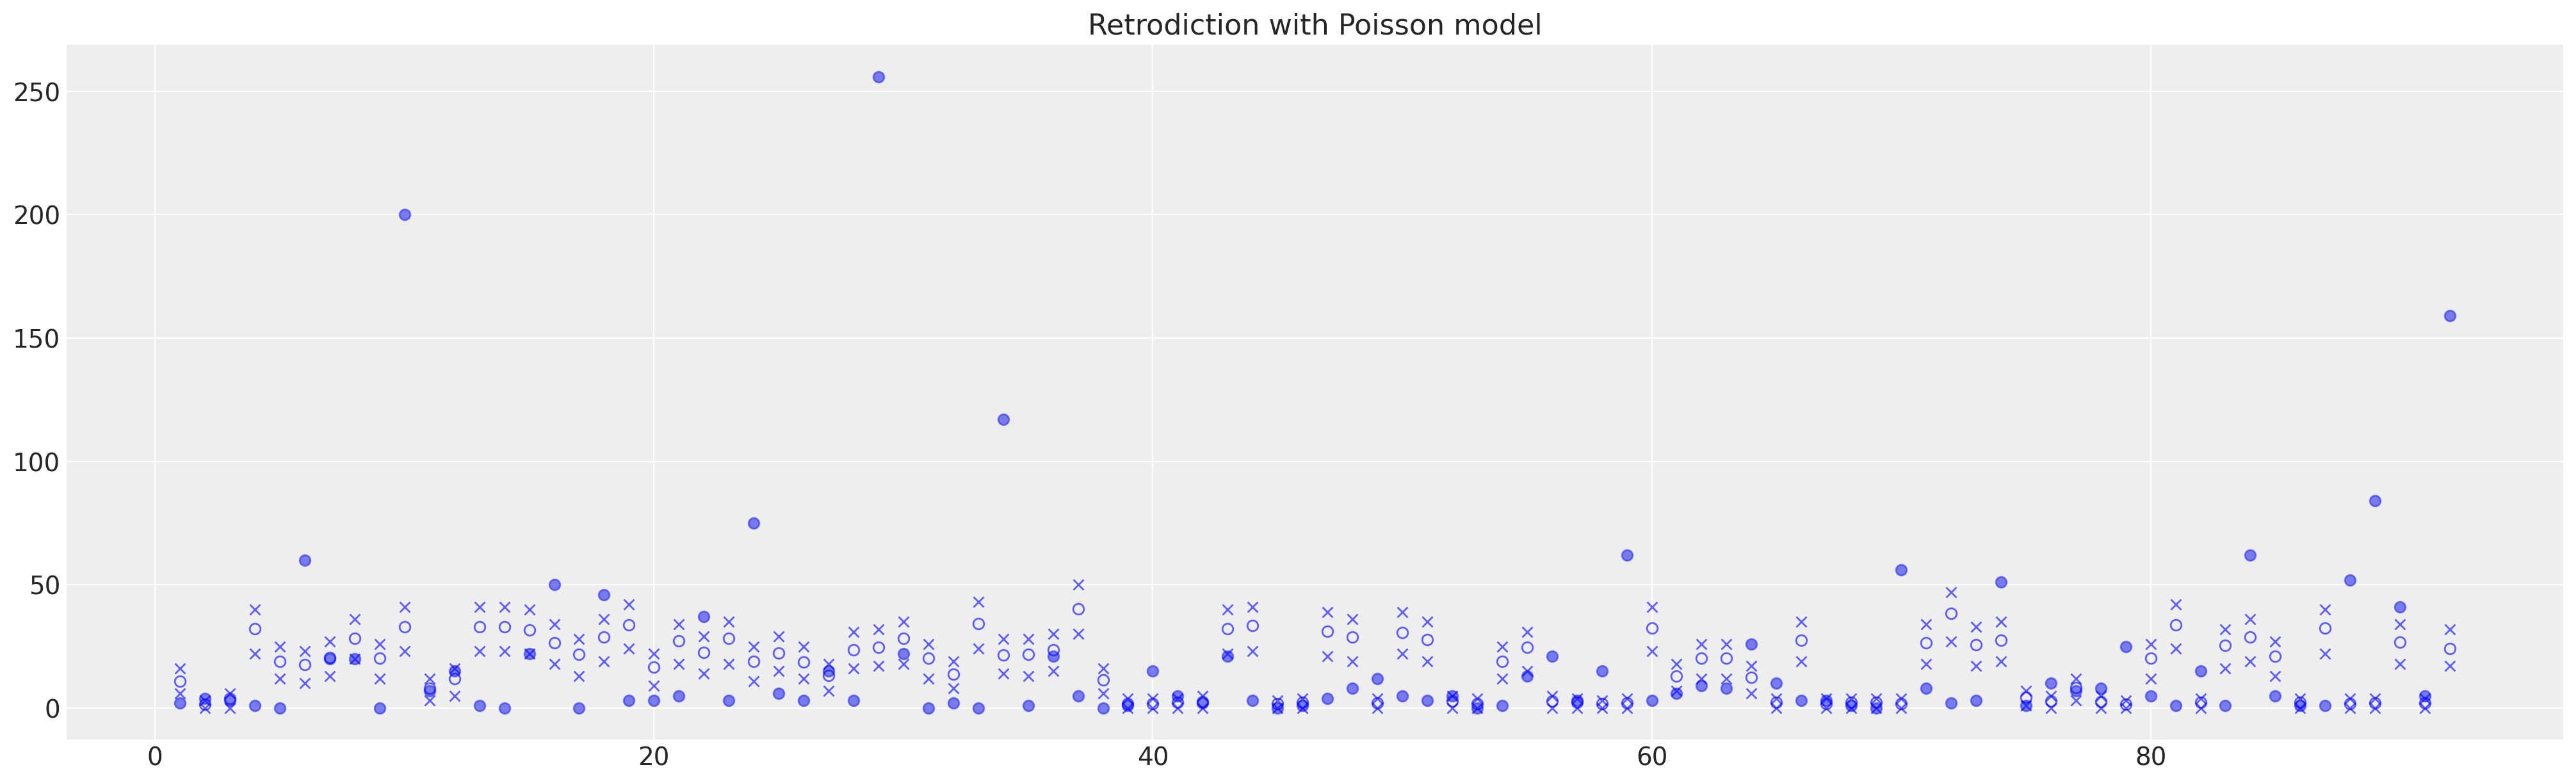

In [19]:
plt.figure(figsize=(20,6))

plt.plot(range(1,df.shape[0]+1), df.deaths, "C0o", ms=6, alpha=0.6)

plt.plot(
    range(1,df.shape[0]+1),
    retro_mh1_1.mean(["chain", "draw"]),
    "bo",
    fillstyle="none",
    ms=6,
    alpha=0.6,
)


plt.plot(np.concatenate((range(1,df.shape[0]+1), range(1,df.shape[0]+1))), 
         np.ravel( az.hdi(retro_mh1_1).to_array().T ), "bx", ms=6, alpha=0.6)

plt.title("Retrodiction with Poisson model")

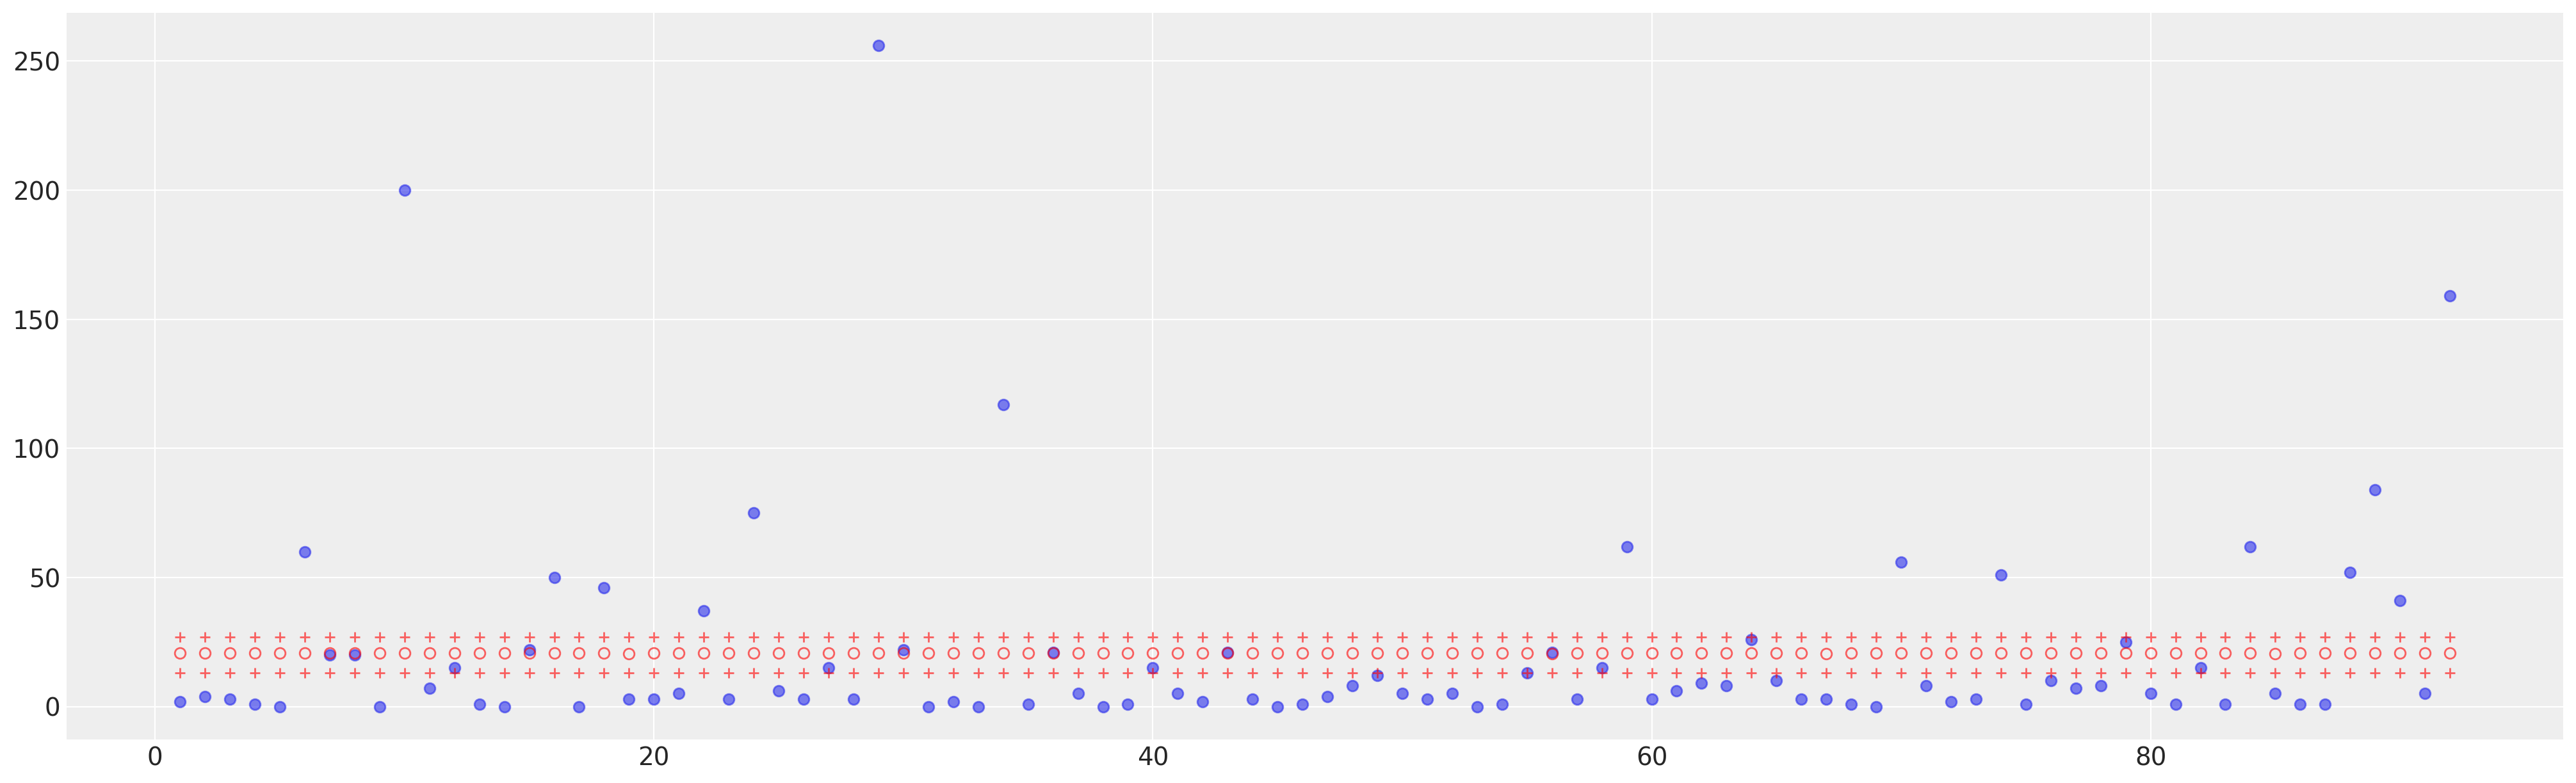

In [20]:
plt.figure(figsize=(20,6))

plt.plot(range(1,df.shape[0]+1), df.deaths, "C0o", ms=6, alpha=0.6)

plt.plot(
    range(1,df.shape[0]+1),
    retro_mh1_2.mean(["chain", "draw"]),
    "ro",
    fillstyle="none",
    ms=6,
    alpha=0.6,
)

plt.plot(np.concatenate((range(1,df.shape[0]+1), range(1,df.shape[0]+1))), 
         np.ravel( az.hdi(retro_mh1_2).to_array().T ), "r+", ms=6, alpha=0.6)

## Exercise 12H2

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, phi]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.


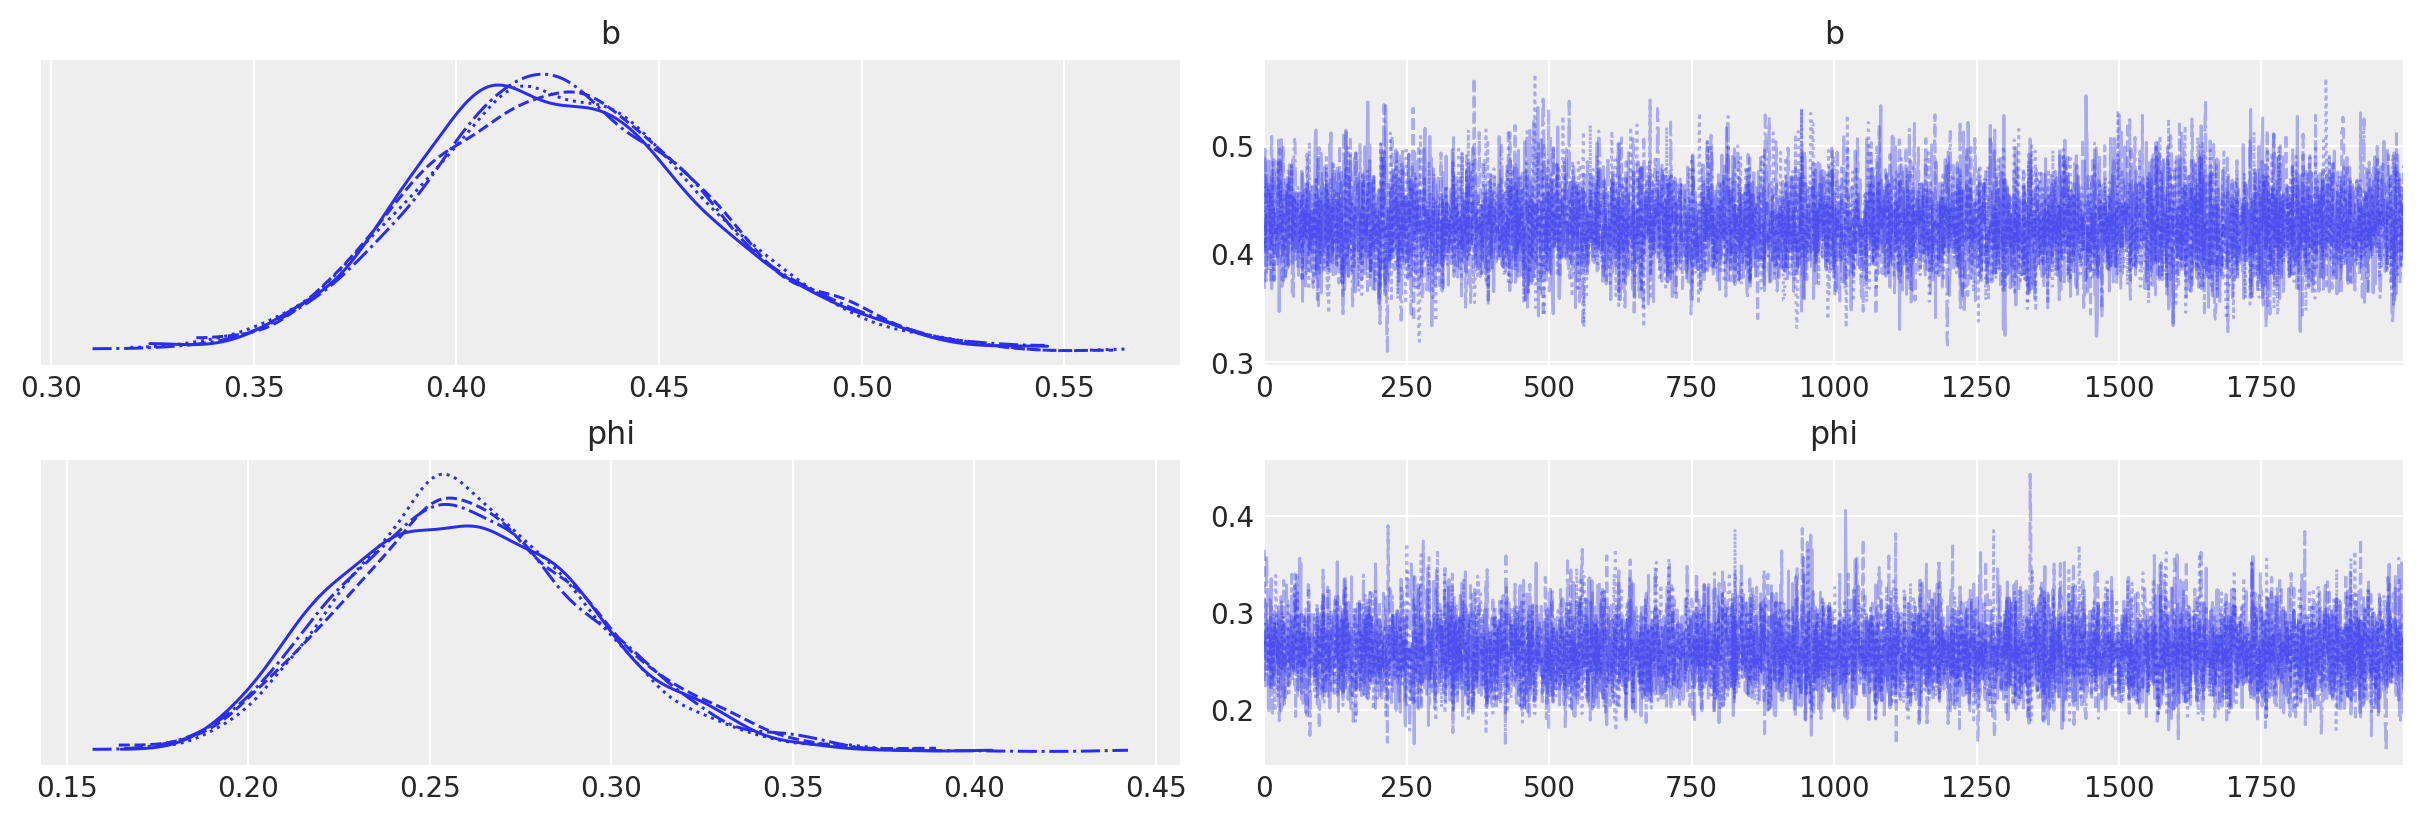

In [21]:
with pm.Model() as mh1_3:
    #a = pm.Lognormal("a", 50, 25, shape=1)
    b = pm.Exponential("b", 0.5, shape=1)
    phi = pm.Exponential("phi", 0.5)
    
    F = pm.MutableData("F",value=df.femininity)
    
    lam = at.exp(b * F)

    T = pm.NegativeBinomial("deaths", lam, phi, observed=df.deaths)

    trace_mh1_3 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)

# store pareto-k values for plot:
k_mh1_3 = az.loo(trace_mh1_3, pointwise=True).pareto_k.values

az.plot_trace(trace_mh1_3, compact=True);

The Gamma-Poisson model has all points with low Pareto's Ks, indicating a more flexible description of the data.

<Axes: xlabel='femininity', ylabel='deaths'>

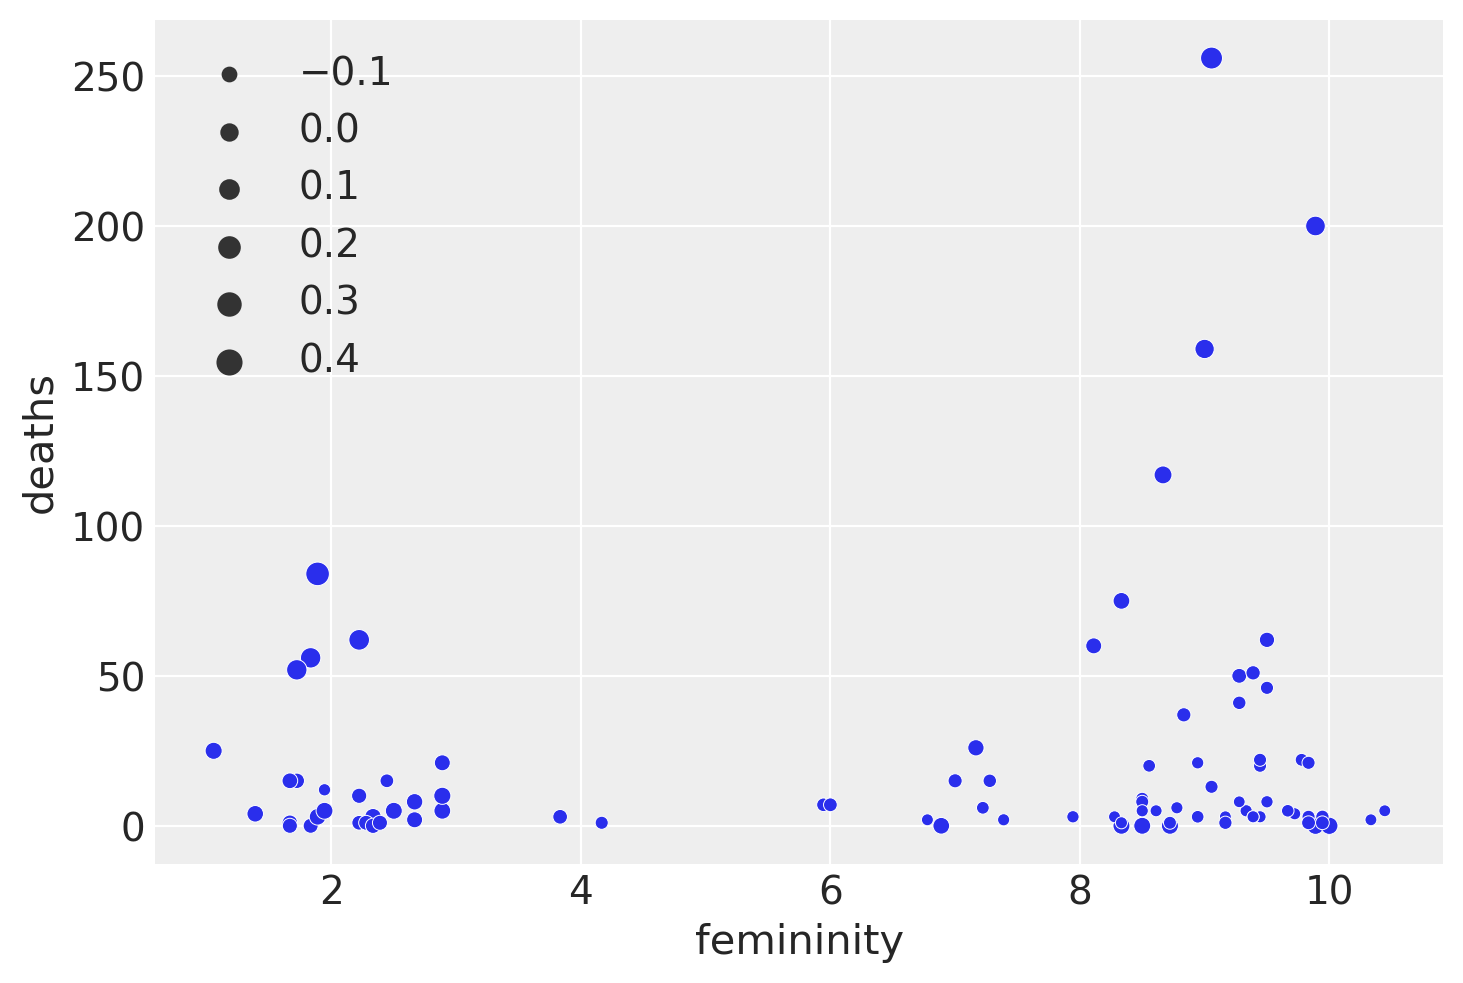

In [22]:
import seaborn as sns
sns.scatterplot(x=df.femininity, y=df.deaths, size=k_mh1_3 )

In [23]:
az.summary(trace_mh1_3, var_names=["b","phi"], round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
b[0]  0.43  0.04      0.37       0.48        0.0      0.0   7069.82   5132.65   
phi   0.26  0.03      0.21       0.31        0.0      0.0   7315.87   5689.43   

      r_hat  
b[0]    1.0  
phi     1.0

In [24]:
with mh1_3:
    retro_mh1_3 = pm.sample_posterior_predictive(trace_mh1_3, var_names=["deaths"])[
        "posterior_predictive"]["deaths"]

Sampling: [deaths]


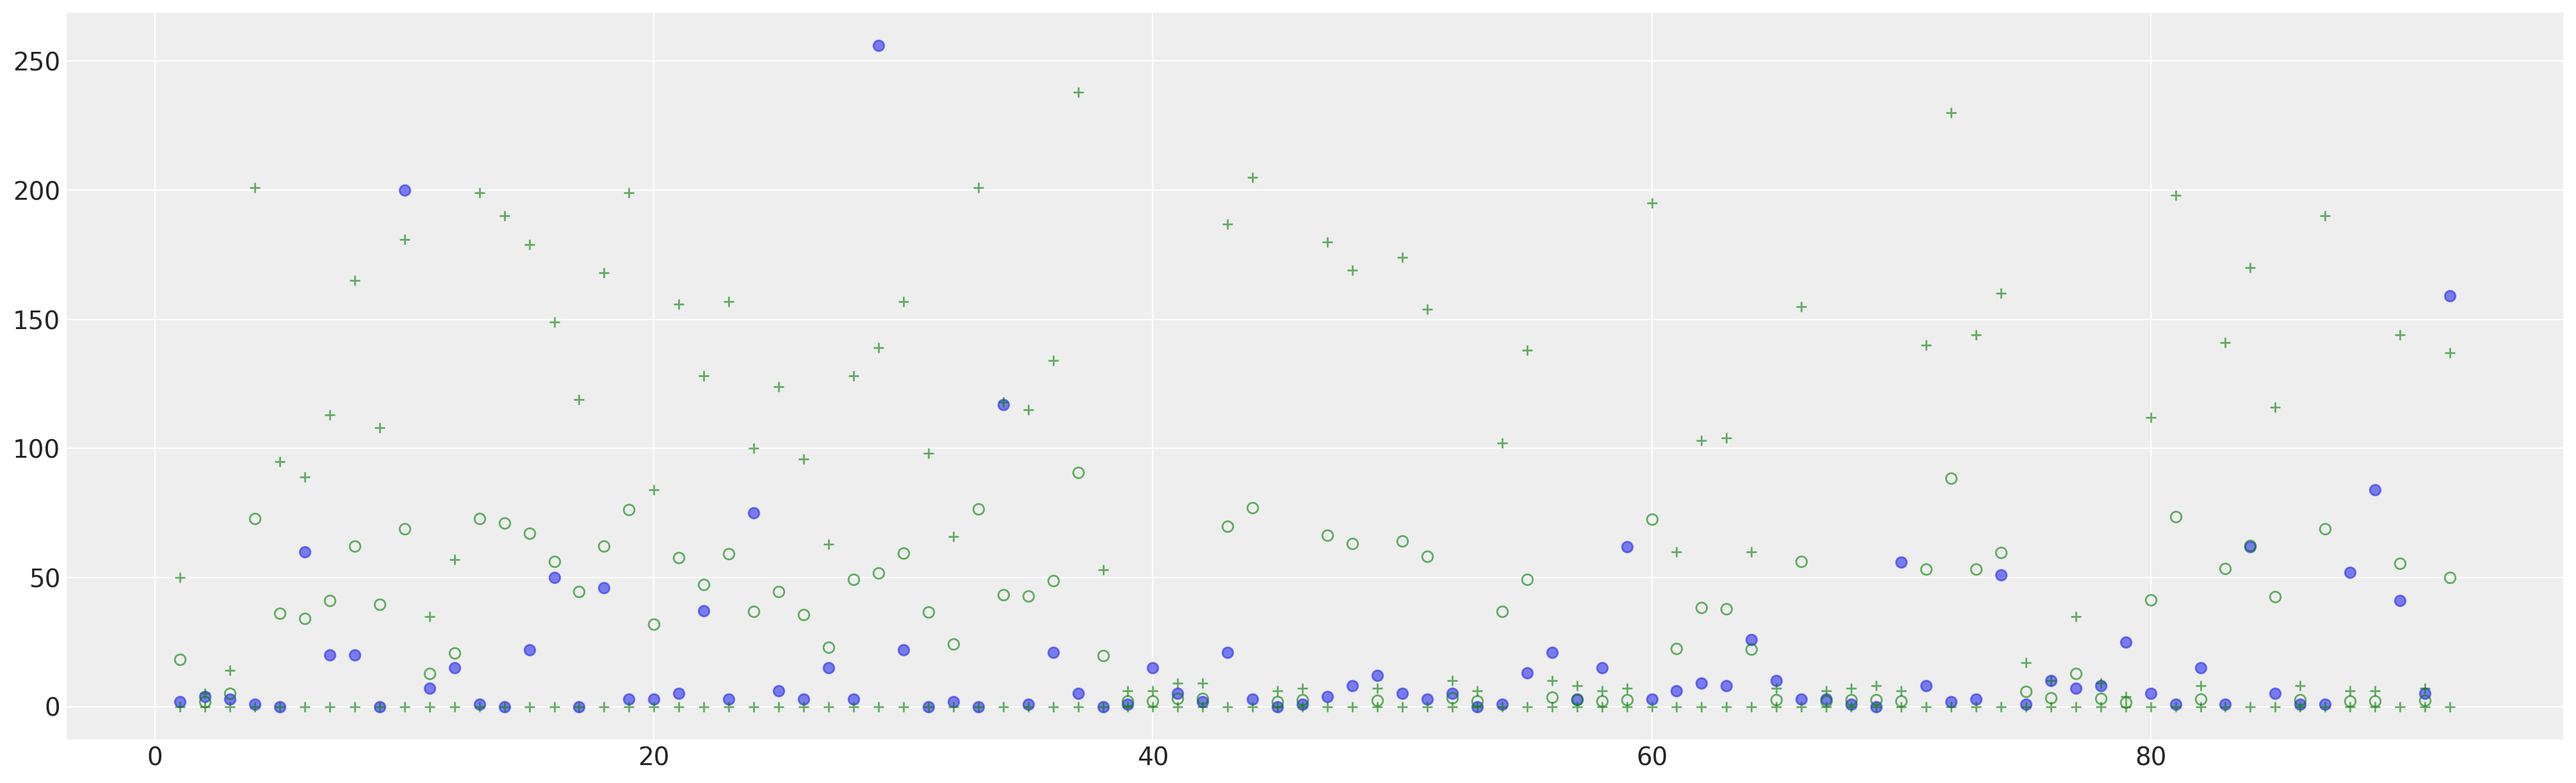

In [25]:
plt.figure(figsize=(20,6))

plt.plot(range(1,df.shape[0]+1), df.deaths, "C0o", ms=6, alpha=0.6)

plt.plot(
    range(1,df.shape[0]+1),
    retro_mh1_3.mean(["chain", "draw"]),
    "go",
    fillstyle="none",
    ms=6,
    alpha=0.6,
)

plt.plot(np.concatenate((range(1,df.shape[0]+1), range(1,df.shape[0]+1))), 
         np.ravel( az.hdi(retro_mh1_3).to_array().T ), "g+", ms=6, alpha=0.6)

## Exercise 12H3

pressure interpolate between 0 and 1, damages in logarithm

In [162]:
df.head()

name  year  deaths  category  min_pressure  damage_norm  female  \
0      Easy  1950       2         3           960         1590       1   
1      King  1950       4         3           955         5350       0   
2      Able  1952       3         1           985          150       0   
3   Barbara  1953       1         1           987           58       1   
4  Florence  1953       0         1           985           15       1   

   femininity  femininity_norm  
0     6.77778         0.609468  
1     1.38889         0.035503  
2     3.83333         0.295857  
3     9.83333         0.934911  
4     8.33333         0.775148

In [29]:
df["min_pressure_norm"] = normalize( df["min_pressure"] )
df["damage_norm_log"] = np.log(df["damage_norm"])

In [30]:
df.describe().round(2)

year  deaths  category  min_pressure  damage_norm  female  \
count    92.00   92.00     92.00         92.00        92.00   92.00   
mean   1982.09   20.65      2.09        964.91      7269.78    0.67   
std      18.77   40.90      1.06         19.07     12934.09    0.47   
min    1950.00    0.00      1.00        909.00         1.00    0.00   
25%    1964.75    2.00      1.00        950.00       245.00    0.00   
50%    1985.00    5.00      2.00        964.00      1650.00    1.00   
75%    1999.00   20.25      3.00        982.25      8162.50    1.00   
max    2012.00  256.00      5.00       1003.00     75000.00    1.00   

       femininity  femininity_norm  min_pressure_norm  damage_norm_log  
count       92.00            92.00              92.00            92.00  
mean         6.78             0.61               0.59             7.17  
std          3.23             0.34               0.20             2.38  
min          1.06             0.00               0.00             0.00  
25%          2.67             0.17               0.44             5.50  
50%          8.50             0.79               0.59             7.41  
75%          9.39             0.89               0.78             9.01  
max         10.44             1.00               1.00            11.23

<Axes: xlabel='femininity', ylabel='min_pressure'>

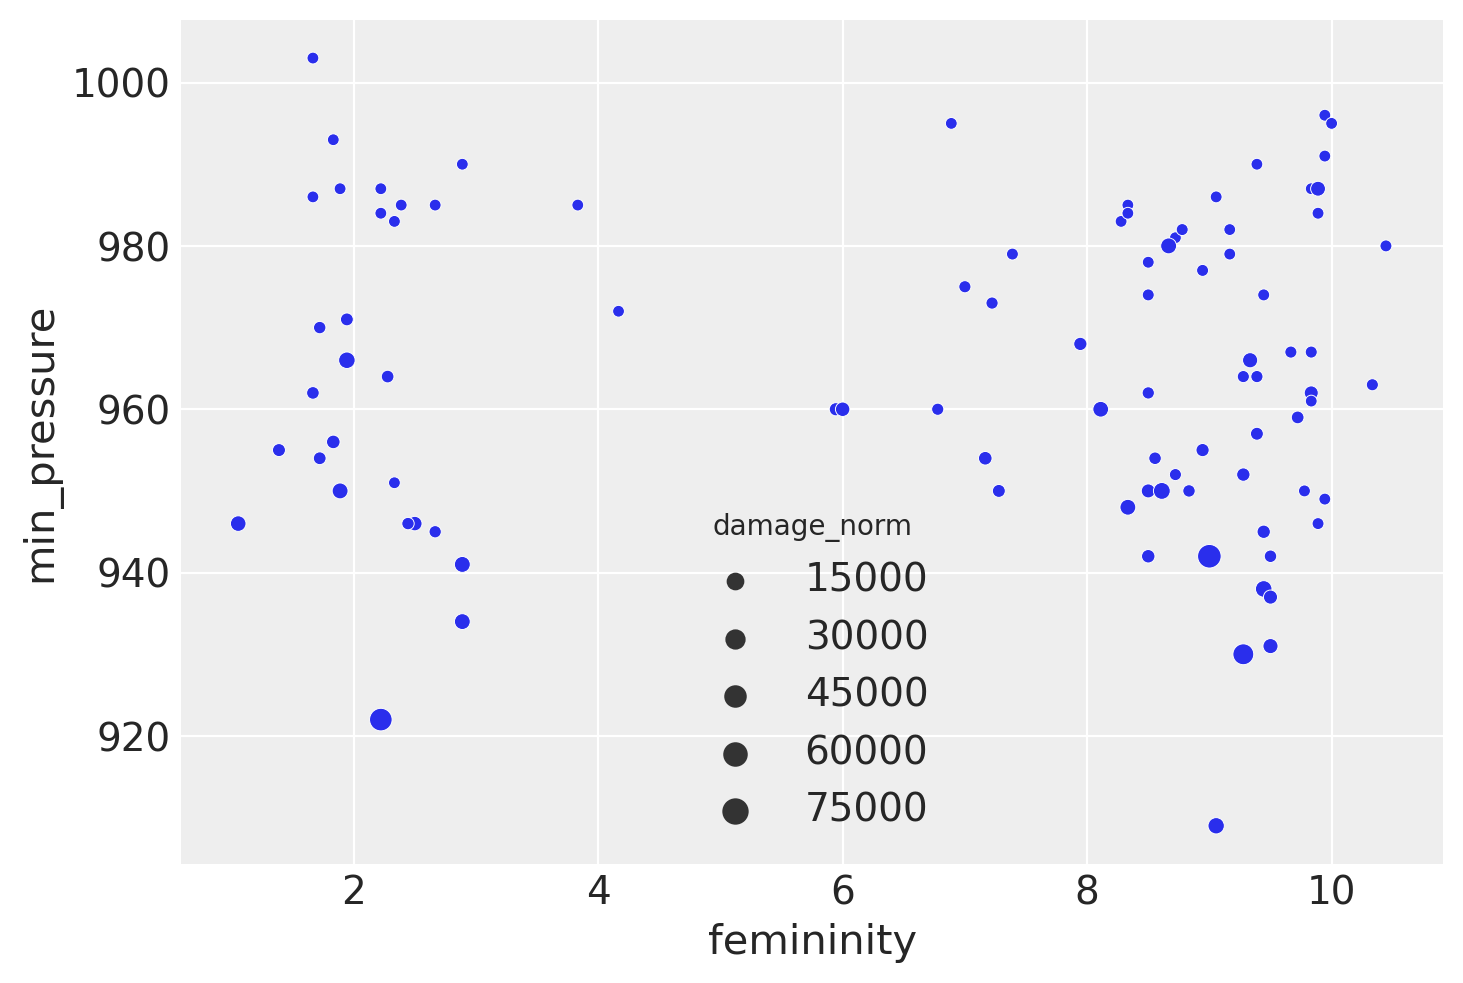

In [31]:
sns.scatterplot(data=df,
                x="femininity",
                y="min_pressure",
                size="damage_norm")

We first try interaction with only pressure and femininity. We will base interactions on the negative binomial model.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, phi]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.
/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


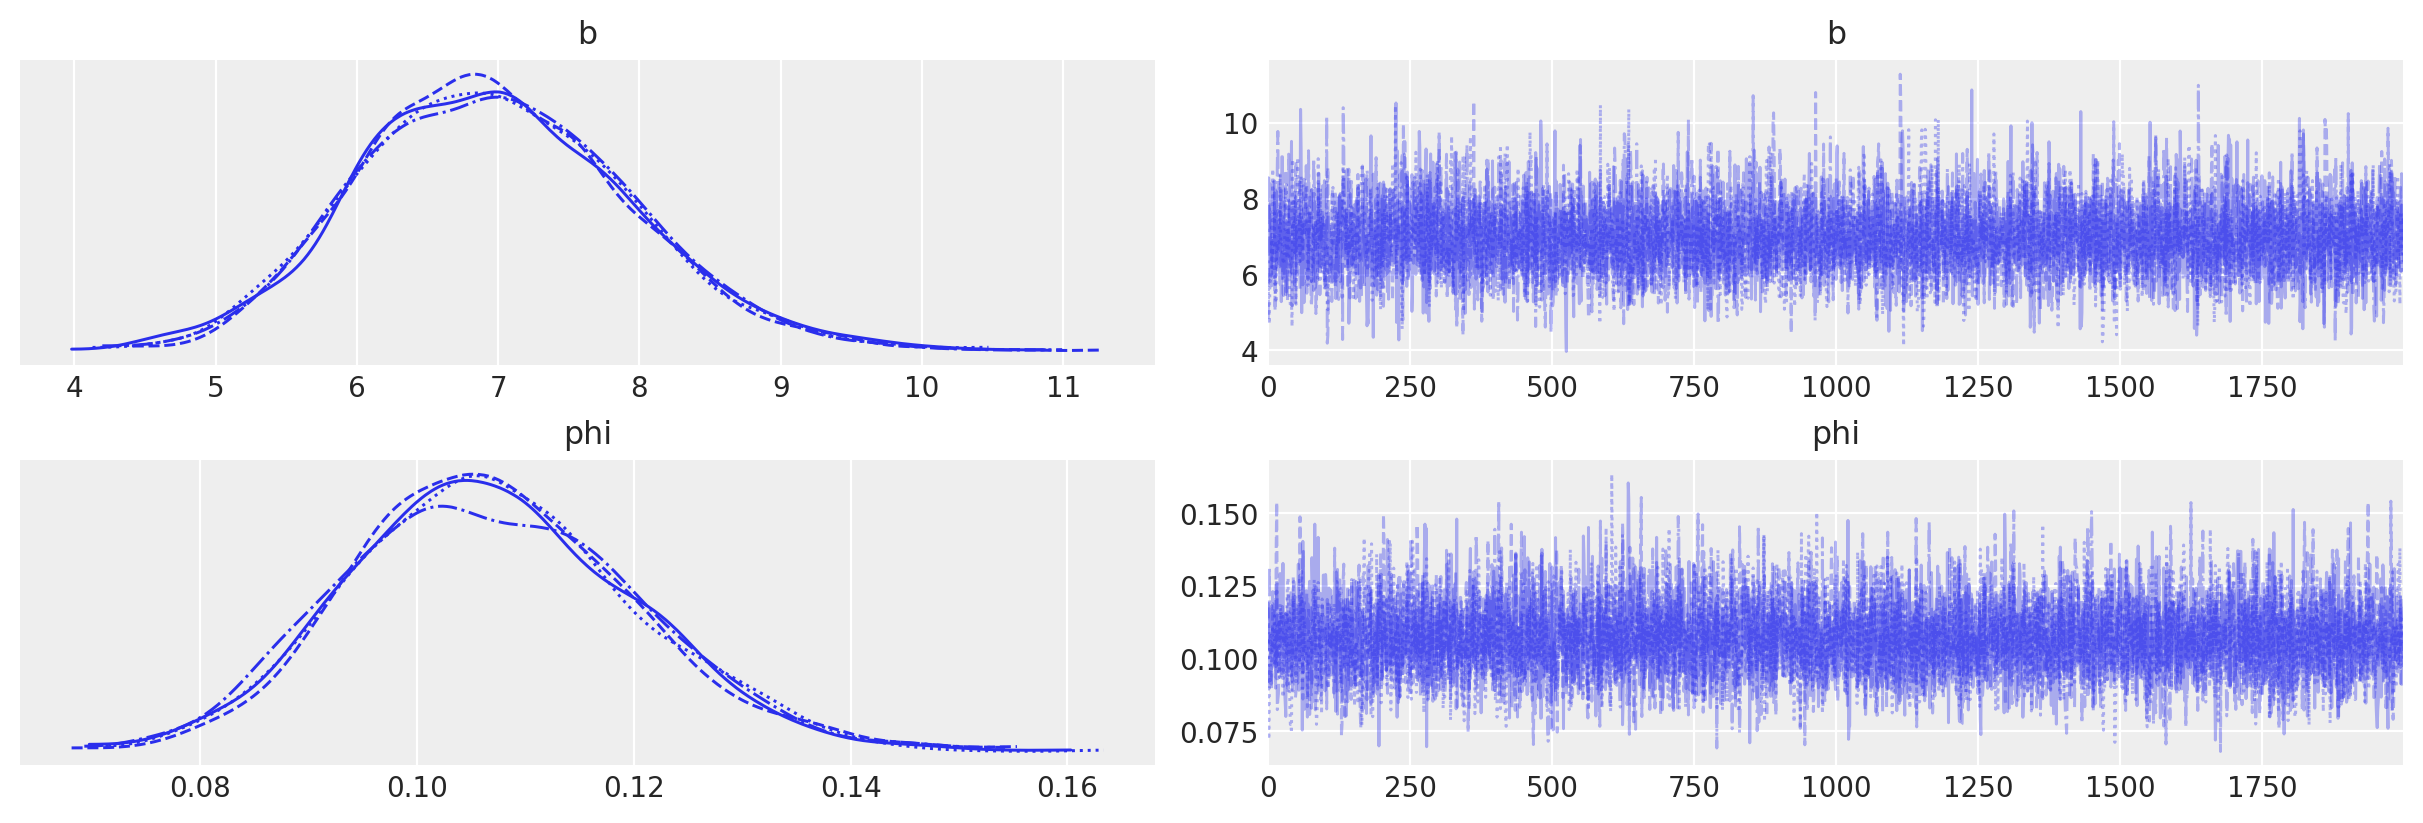

In [32]:
with pm.Model() as mh1_5:
    b = pm.Exponential("b", 1, shape=1)
    phi = pm.Exponential("phi", 0.5)
    
    F = pm.MutableData("F",value=df.femininity_norm)
    P = pm.MutableData("P",value=df.min_pressure_norm)
    
    lam = at.exp(b * F * P)

    T = pm.NegativeBinomial("deaths", lam, phi, observed=df.deaths)

    trace_mh1_5 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)

# store pareto-k values for plot:
k_mh1_5 = az.loo(trace_mh1_5, pointwise=True).pareto_k.values

az.plot_trace(trace_mh1_5, compact=True);

The Interaction reduces the Pareto K values, which is a good thing.

<Axes: xlabel='femininity', ylabel='deaths'>

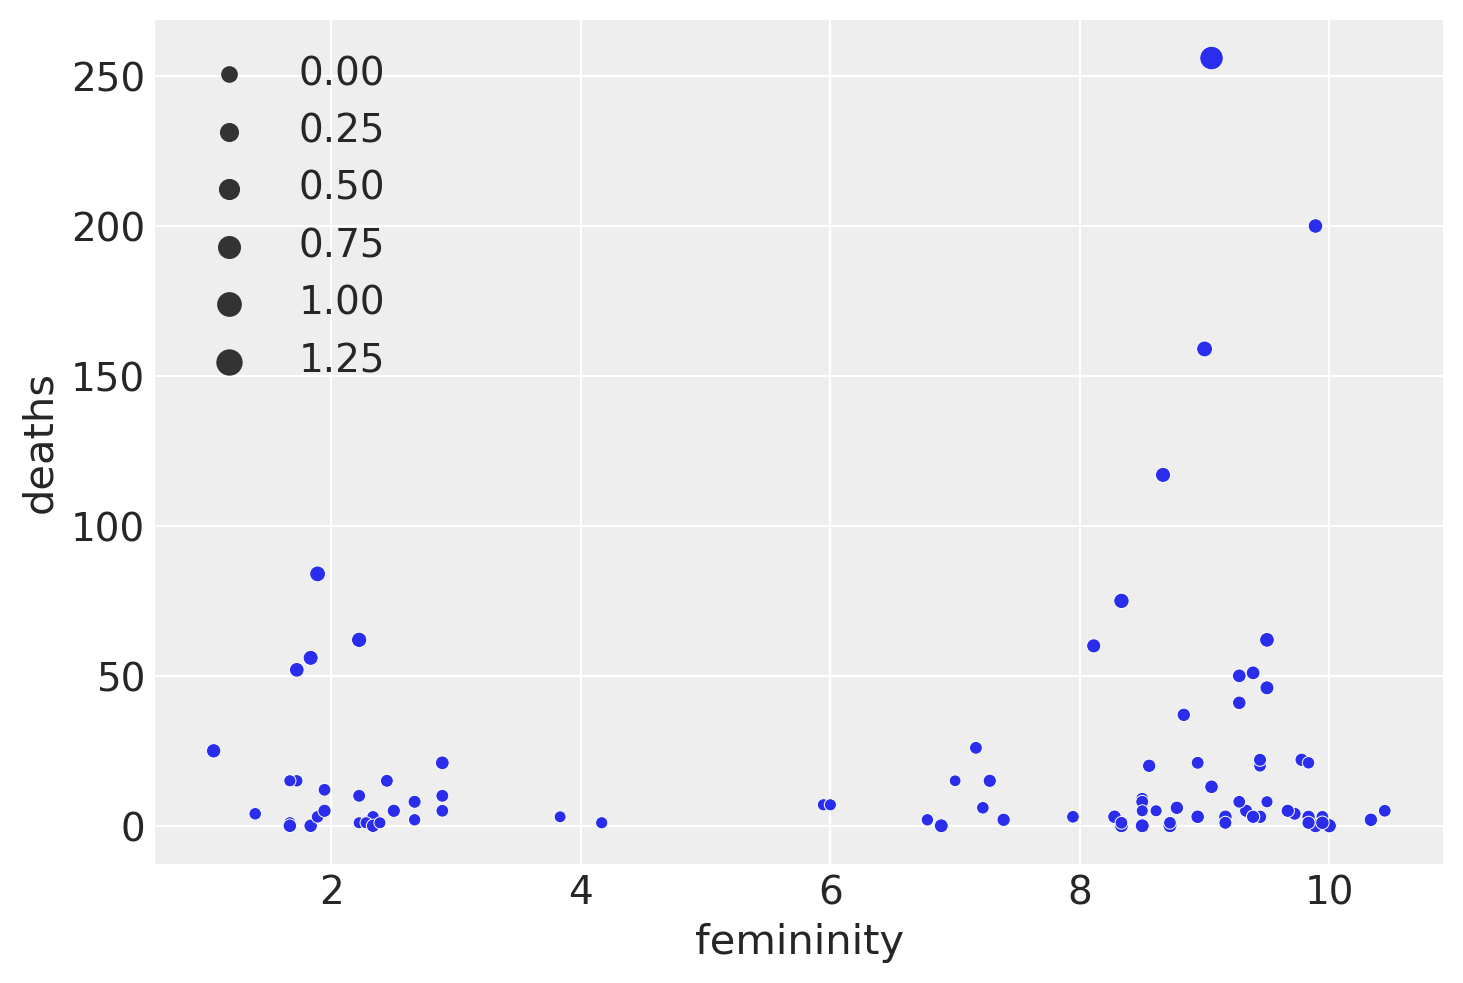

In [33]:
import seaborn as sns
sns.scatterplot(x=df.femininity, y=df.deaths, size=k_mh1_5 )

In [34]:
az.summary(trace_mh1_3, var_names=["b","phi"], round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
b[0]  0.43  0.04      0.37       0.48        0.0      0.0   7069.82   5132.65   
phi   0.26  0.03      0.21       0.31        0.0      0.0   7315.87   5689.43   

      r_hat  
b[0]    1.0  
phi     1.0

In [35]:
az.summary(trace_mh1_5, var_names=["b","phi"], round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
b[0]  6.97  0.96      5.44       8.45       0.01     0.01   6399.53   5154.07   
phi   0.11  0.01      0.09       0.13       0.00     0.00   7017.63   5564.02   

      r_hat  
b[0]    1.0  
phi     1.0

In [36]:
with mh1_5:
    retro_mh1_5 = pm.sample_posterior_predictive(trace_mh1_5, var_names=["deaths"])[
        "posterior_predictive"]["deaths"]

Sampling: [deaths]


We can now see how the model covers large intervals in retrodicting the original data (in log scale for better visualization). The retrodiction itself is not good, but what is important is that our uncertainty captures the data itself.

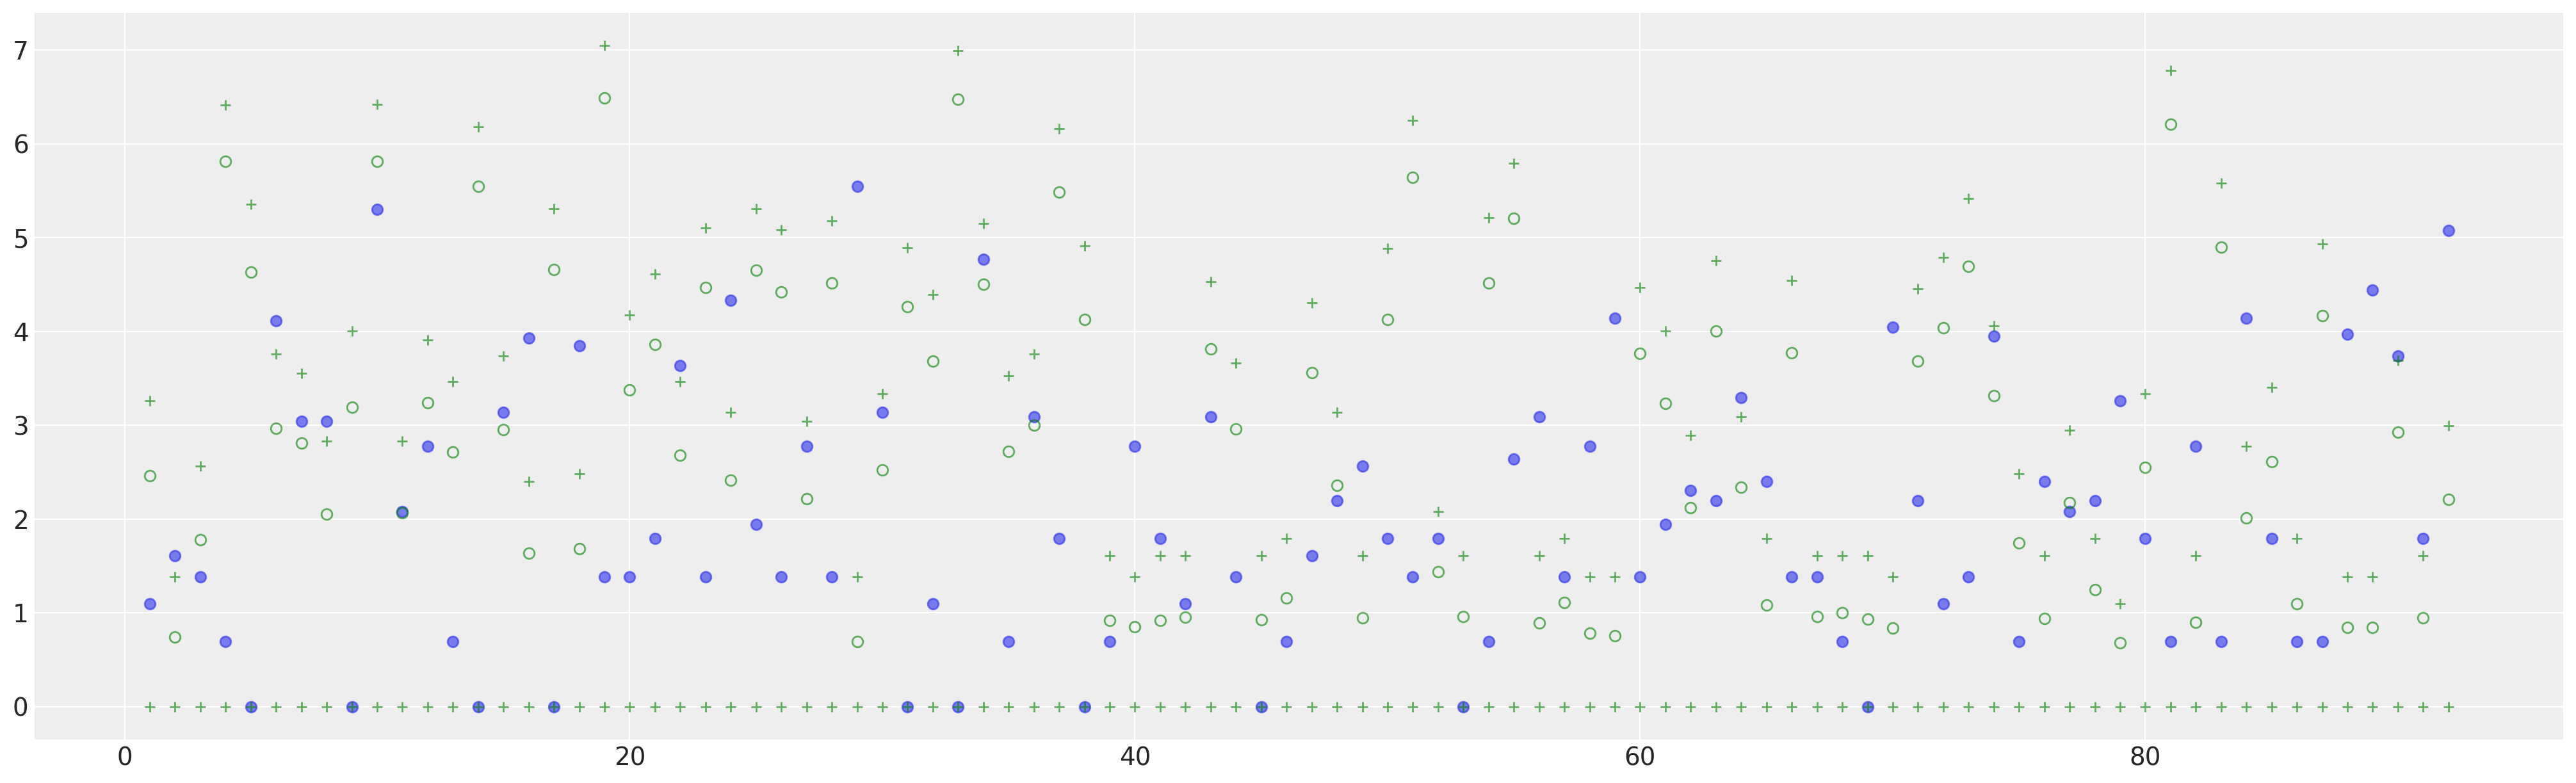

In [37]:
plt.figure(figsize=(20,6))

plt.plot(range(1,df.shape[0]+1), np.log1p( df.deaths ), "C0o", ms=6, alpha=0.6)

plt.plot(
    range(1,df.shape[0]+1),
    np.log1p( retro_mh1_5.mean(["chain", "draw"]) ),
    "go",
    fillstyle="none",
    ms=6,
    alpha=0.6,
)

plt.plot(np.concatenate((range(1,df.shape[0]+1), range(1,df.shape[0]+1))), 
         np.log1p( np.ravel( az.hdi(retro_mh1_5).to_array().T ) ), "g+", ms=6, alpha=0.6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, phi]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.


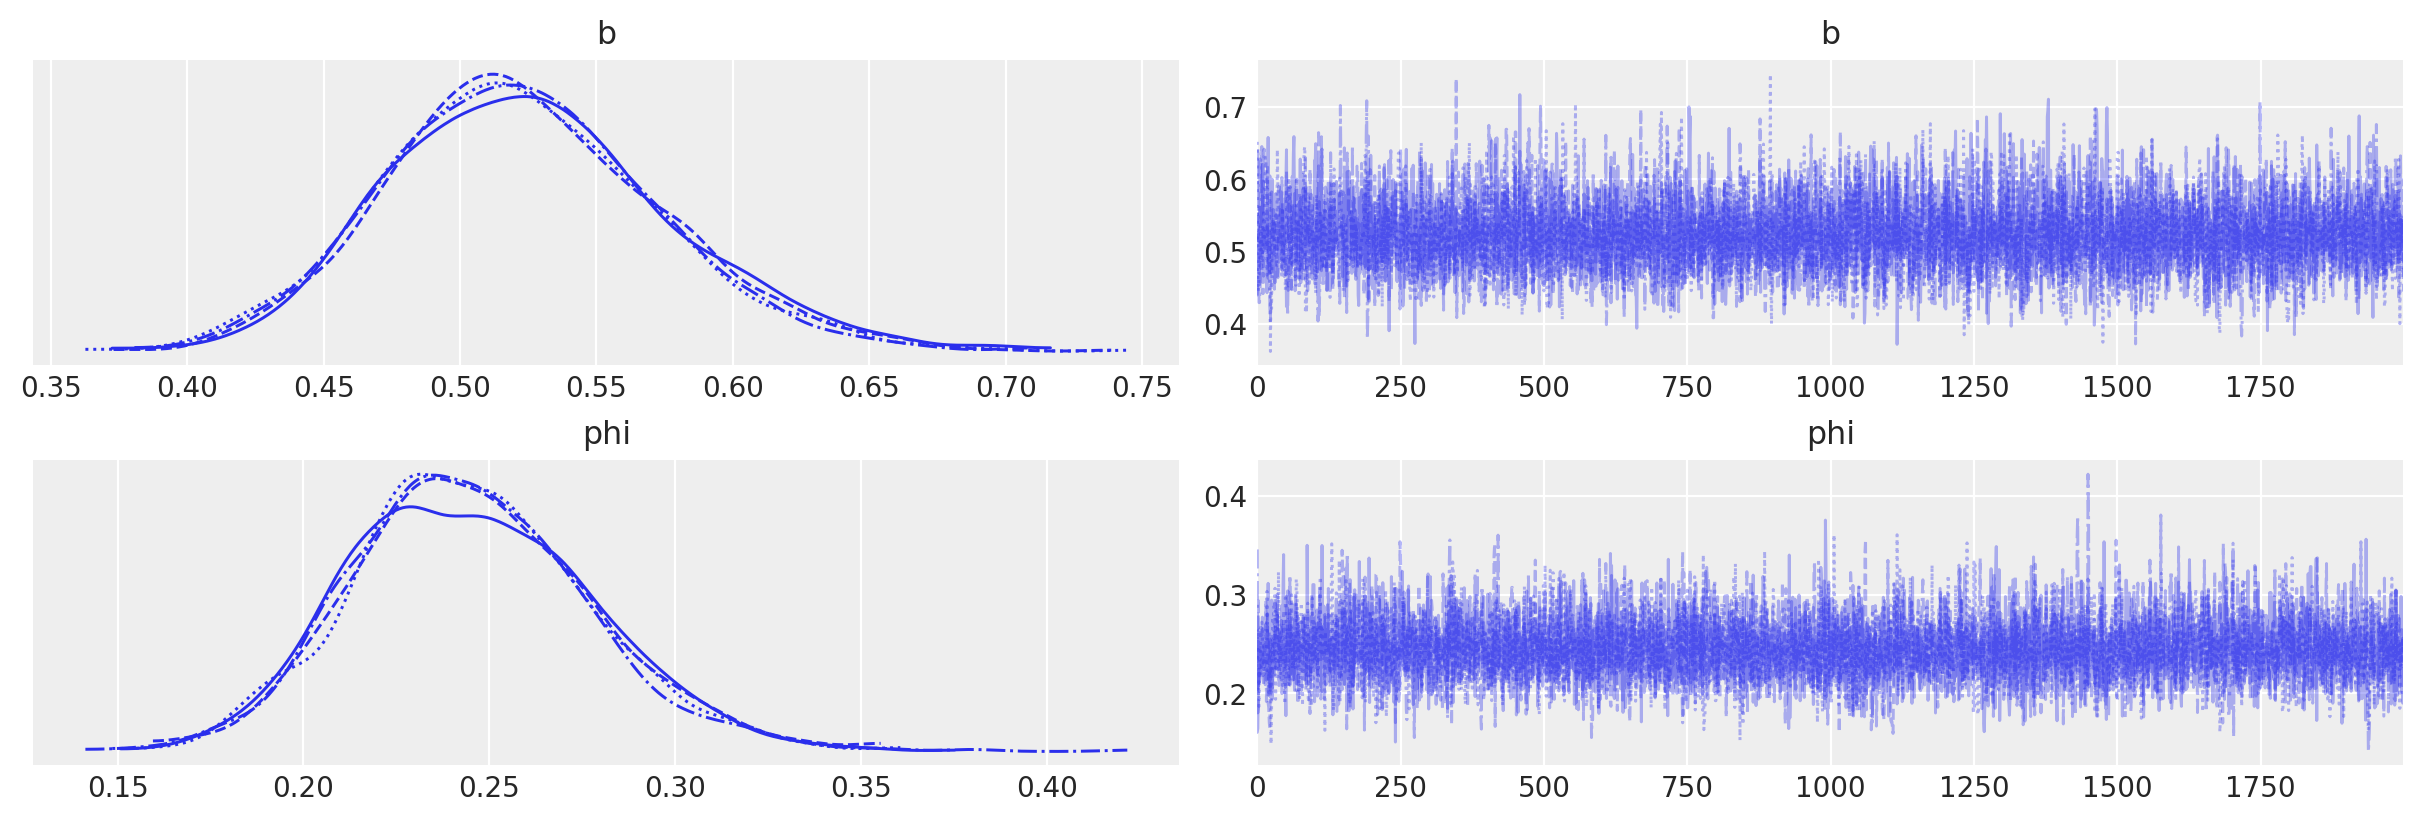

In [38]:
with pm.Model() as mh1_6:
    b = pm.Exponential("b", 1, shape=1)
    phi = pm.Exponential("phi", 0.5)
    
    F = pm.MutableData("F",value=df.femininity_norm)
    D = pm.MutableData("D",value=df.damage_norm_log)
    
    lam = at.exp(b * F * D)

    T = pm.NegativeBinomial("deaths", lam, phi, observed=df.deaths)

    trace_mh1_6 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)

# store pareto-k values for plot:
k_mh1_6 = az.loo(trace_mh1_6, pointwise=True).pareto_k.values

az.plot_trace(trace_mh1_6, compact=True);

The Interaction with the damage provides even better Ks for the Pareto LOO.

<Axes: xlabel='femininity', ylabel='deaths'>

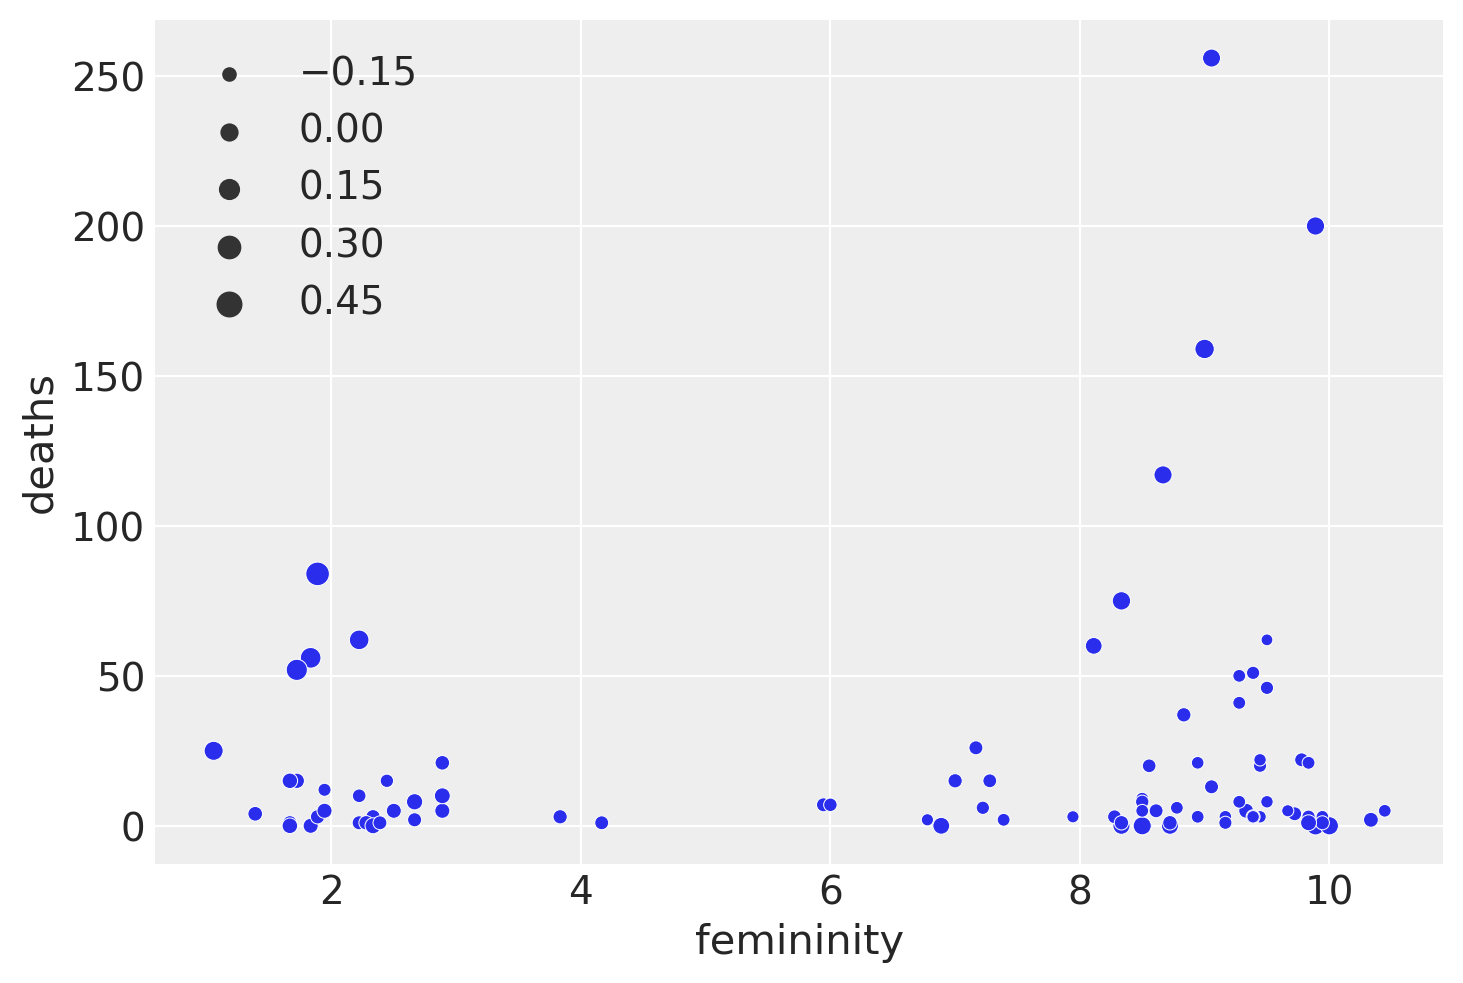

In [39]:
import seaborn as sns
sns.scatterplot(x=df.femininity, y=df.deaths, size=k_mh1_6 )

In [40]:
az.summary(trace_mh1_6, var_names=["b","phi"], round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
b[0]  0.52  0.05      0.45       0.60        0.0      0.0   7128.56   5508.30   
phi   0.24  0.03      0.19       0.29        0.0      0.0   6981.80   5518.51   

      r_hat  
b[0]    1.0  
phi     1.0

In [41]:
az.summary(trace_mh1_5, var_names=["b","phi"], round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
b[0]  6.97  0.96      5.44       8.45       0.01     0.01   6399.53   5154.07   
phi   0.11  0.01      0.09       0.13       0.00     0.00   7017.63   5564.02   

      r_hat  
b[0]    1.0  
phi     1.0

In [42]:
with mh1_6:
    retro_mh1_6 = pm.sample_posterior_predictive(trace_mh1_6, var_names=["deaths"])[
        "posterior_predictive"]["deaths"]

Sampling: [deaths]


Retrodiction seems slightly better than with the pressure interaction.

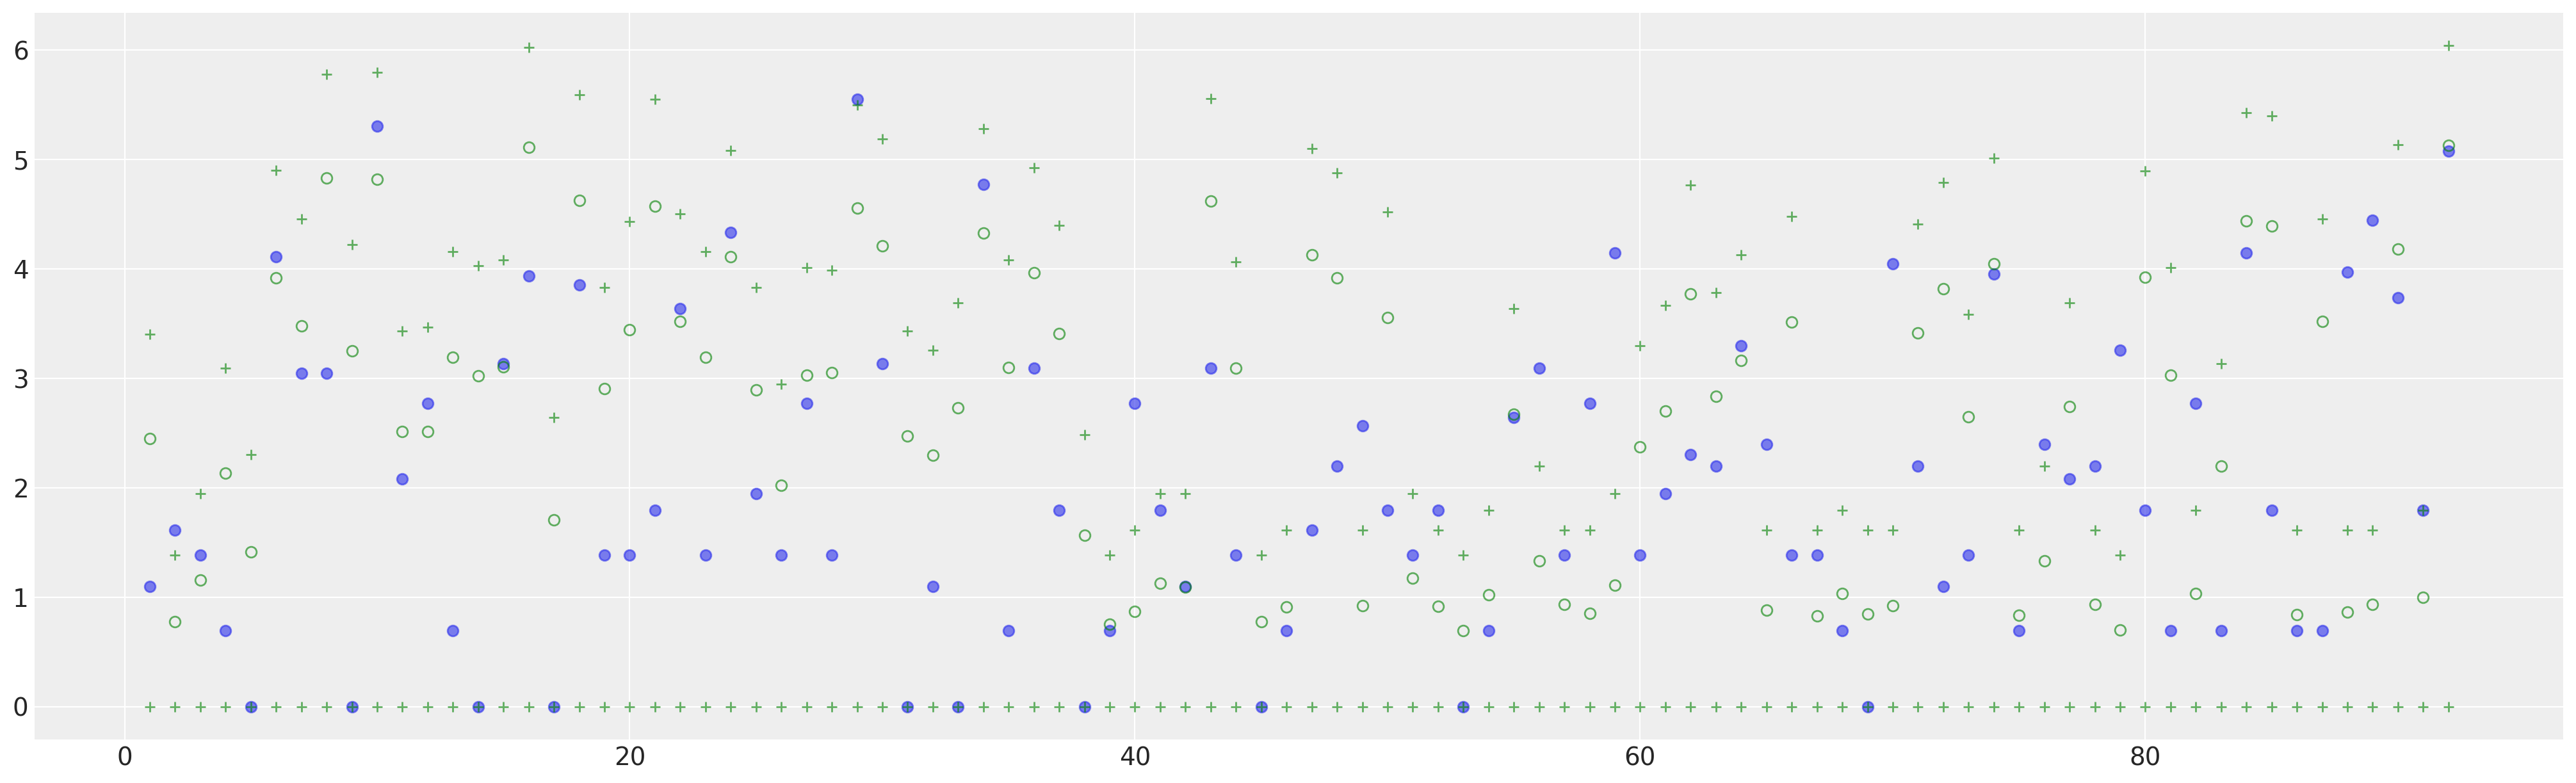

In [43]:
plt.figure(figsize=(20,6))

plt.plot(range(1,df.shape[0]+1), np.log1p( df.deaths ), "C0o", ms=6, alpha=0.6)

plt.plot(
    range(1,df.shape[0]+1),
    np.log1p( retro_mh1_6.mean(["chain", "draw"]) ),
    "go",
    fillstyle="none",
    ms=6,
    alpha=0.6,
)

plt.plot(np.concatenate((range(1,df.shape[0]+1), range(1,df.shape[0]+1))), 
         np.log1p( np.ravel( az.hdi(retro_mh1_6).to_array().T ) ), "g+", ms=6, alpha=0.6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, phi]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.
/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


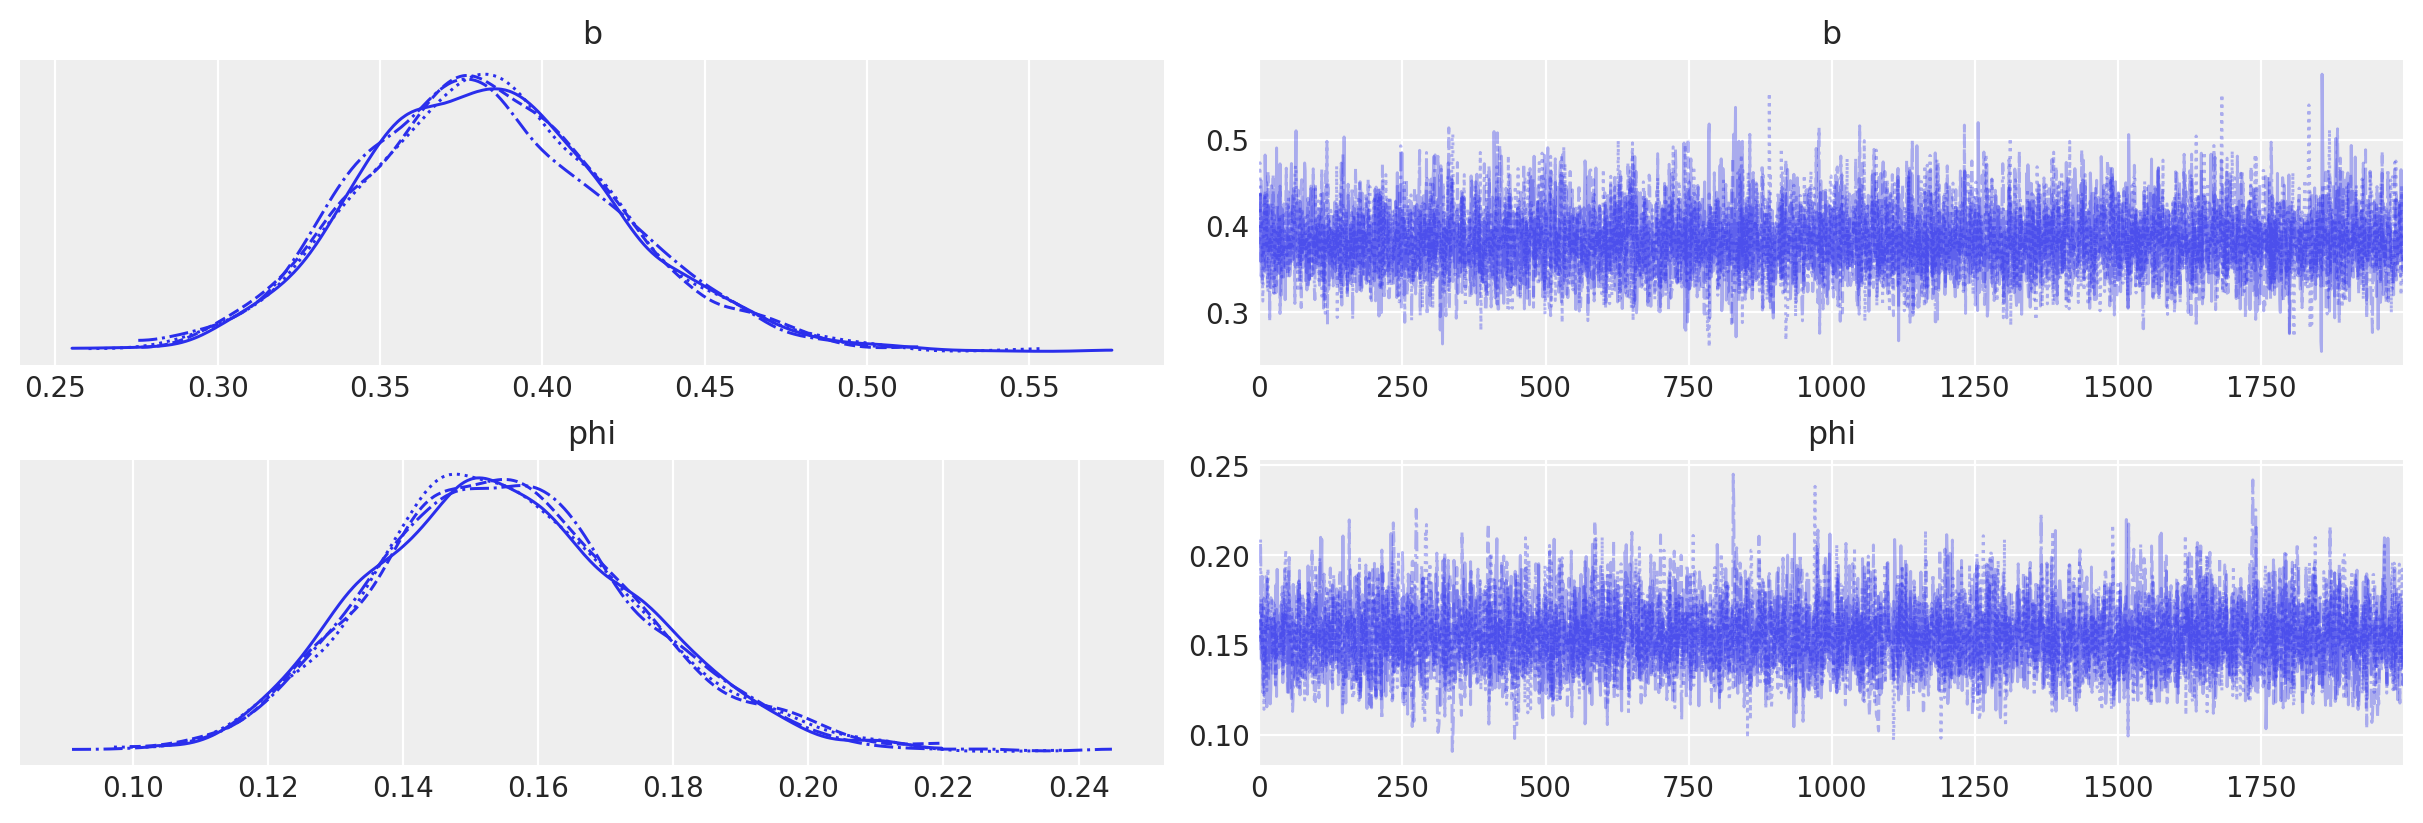

In [50]:
with pm.Model() as mh1_7:
    b = pm.Exponential("b", 1, shape=1)
    phi = pm.Exponential("phi", 0.5)
    
    F = pm.MutableData("F",value=df.femininity)
    P = pm.MutableData("P",value=df.min_pressure_norm)
    D = pm.MutableData("D",value=df.damage_norm_log)
    
    lam = at.exp(b  * P * (F + D))

    T = pm.NegativeBinomial("deaths", lam, phi, observed=df.deaths)

    trace_mh1_7 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)

# store pareto-k values for plot:
k_mh1_7 = az.loo(trace_mh1_7, pointwise=True).pareto_k.values

az.plot_trace(trace_mh1_7, compact=True);

The Interaction reduces the Pareto K values, which is a good thing.

<Axes: xlabel='femininity', ylabel='deaths'>

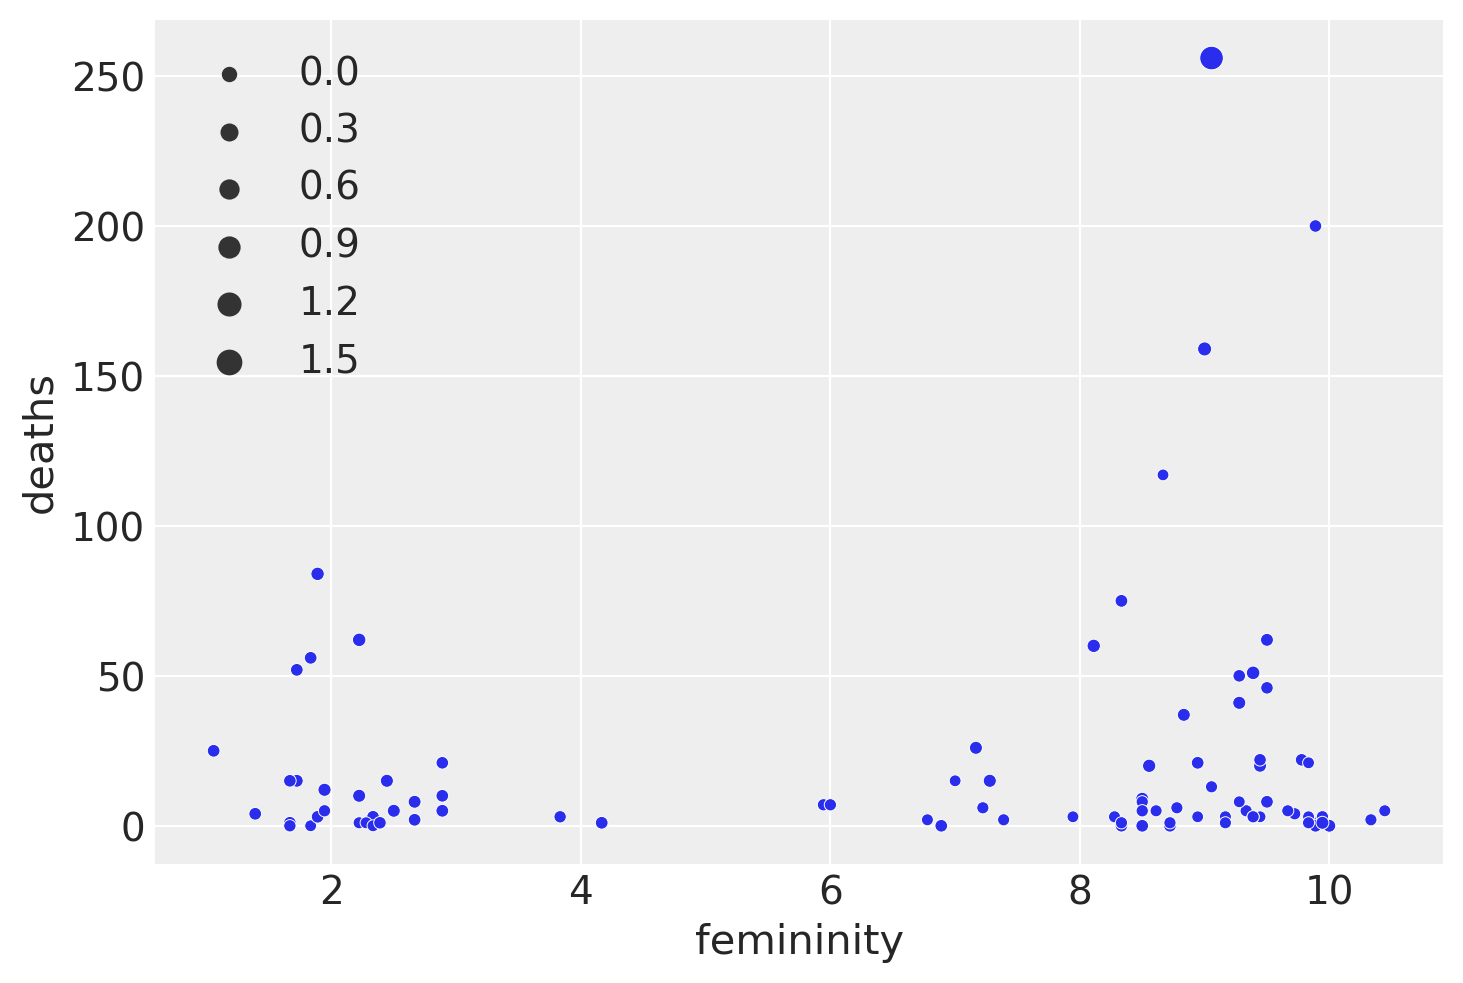

In [51]:
import seaborn as sns
sns.scatterplot(x=df.femininity, y=df.deaths, size=k_mh1_7 )

In [52]:
az.summary(trace_mh1_7, var_names=["b","phi"], round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
b[0]  0.38  0.04      0.32       0.44        0.0      0.0   8117.41   5778.55   
phi   0.16  0.02      0.12       0.18        0.0      0.0   6773.49   5070.22   

      r_hat  
b[0]    1.0  
phi     1.0

In [53]:
with mh1_7:
    retro_mh1_7 = pm.sample_posterior_predictive(trace_mh1_7, var_names=["deaths"])[
        "posterior_predictive"]["deaths"]

Sampling: [deaths]


We can now see how the model covers large intervals in retrodicting the original data (in log scale for better visualization). The retrodiction itself is not good, but what is important is that our uncertainty captures the data itself.

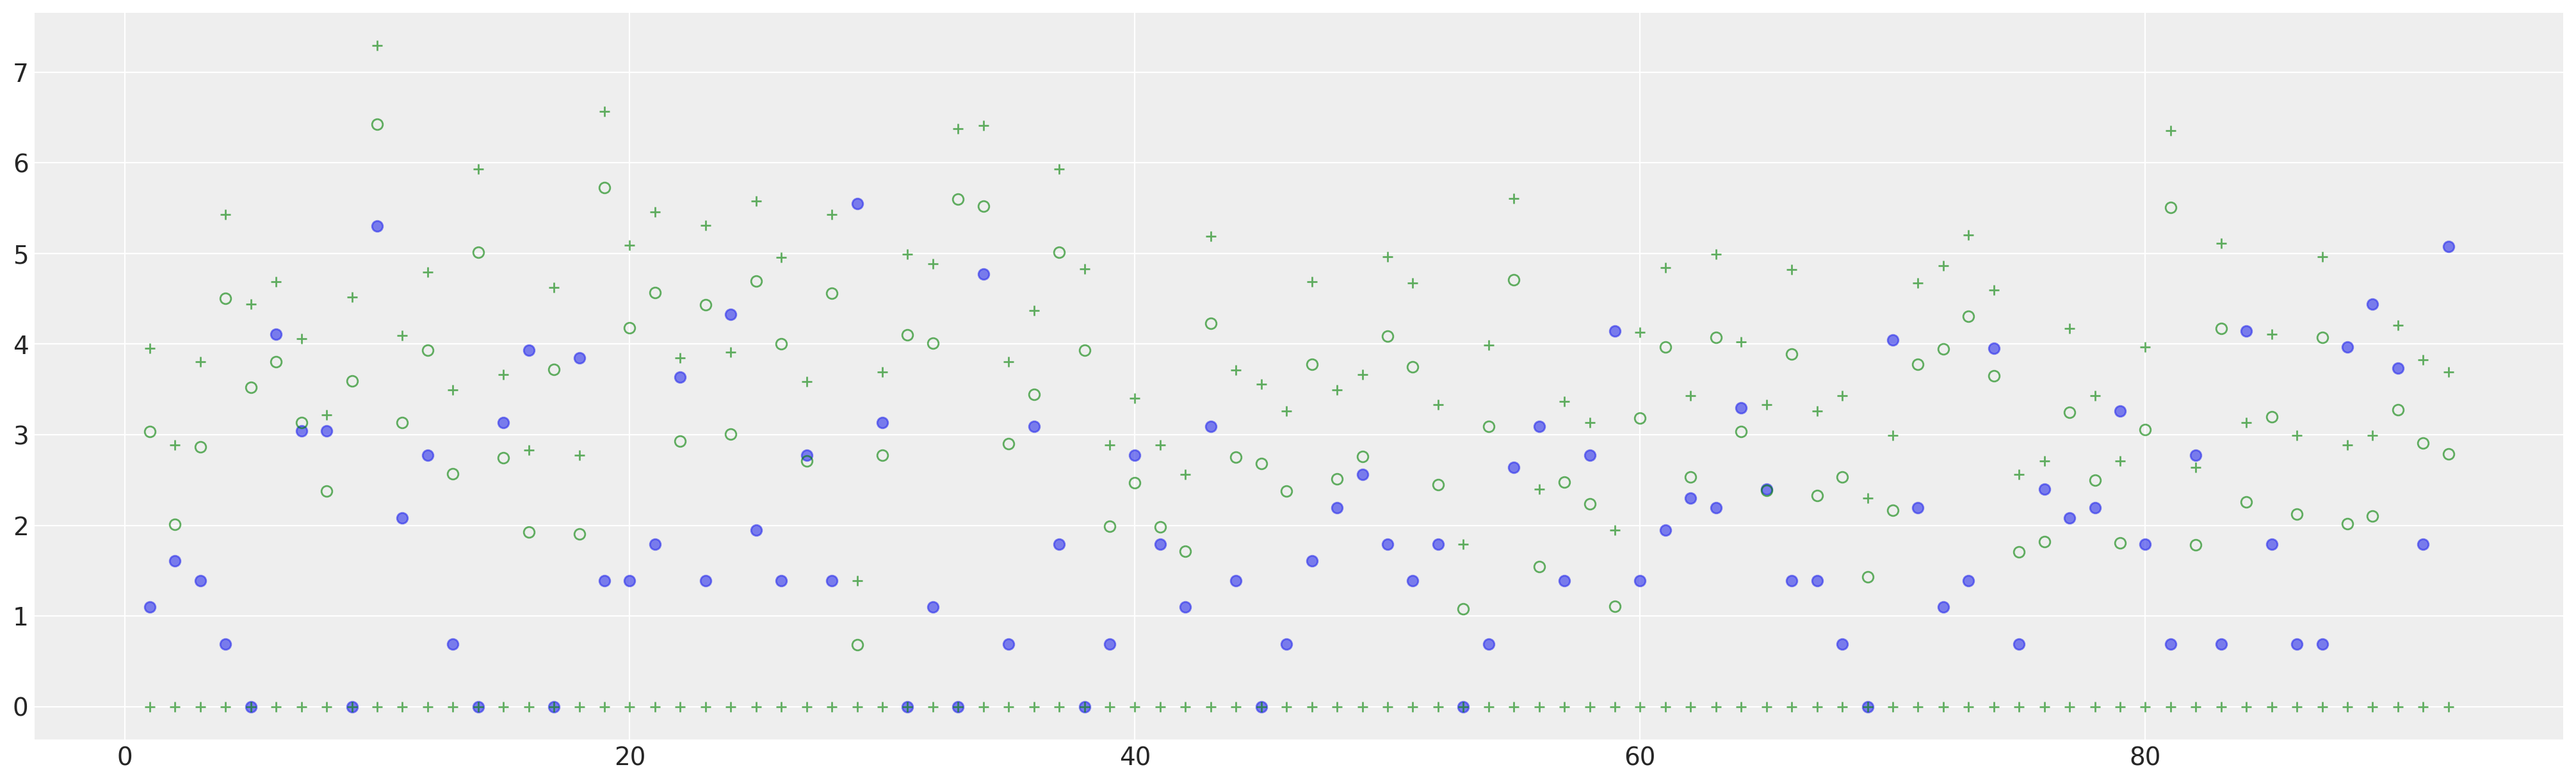

In [54]:
plt.figure(figsize=(20,6))

plt.plot(range(1,df.shape[0]+1), np.log1p( df.deaths ), "C0o", ms=6, alpha=0.6)

plt.plot(
    range(1,df.shape[0]+1),
    np.log1p( retro_mh1_7.mean(["chain", "draw"]) ),
    "go",
    fillstyle="none",
    ms=6,
    alpha=0.6,
)

plt.plot(np.concatenate((range(1,df.shape[0]+1), range(1,df.shape[0]+1))), 
         np.log1p( np.ravel( az.hdi(retro_mh1_7).to_array().T ) ), "g+", ms=6, alpha=0.6)

A Pareto LOO comparison clearly establishes that the interaction with damages is best. This makes sense, because damages should be higher in more devastating (and at the same time likely deadlier) tornadoes. At this point it would be nice to see if it makes sense at all to include femininity in our prediction. The pressure should also give some useful information in theory, but some hurricanes might be very powerful (high pressure) in scarcely populated area, and thus the relationship with deaths would not be present.

In [56]:
az.compare({"P * F": trace_mh1_5, "P * D": trace_mh1_6, "P * (F + D)": trace_mh1_7})

/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likel

rank    elpd_loo      p_loo  elpd_diff        weight         se  \
P * D           0 -395.273365   4.875653   0.000000  7.558833e-01  27.357337   
P * (F + D)     1 -433.162007  17.484712  37.888641  2.441167e-01  52.175903   
P * F           2 -455.049285  10.299435  59.775919  2.775558e-15  40.651457   

                   dse  warning scale  
P * D         0.000000    False   log  
P * (F + D)  47.984966     True   log  
P * F        31.354147     True   log

It seems the femininity-only model (with negative binomial) is best, according to LOO, even though the difference in number of parameters is small. Note however how both models have no warnings on the k values.

In [57]:
az.compare({"F": trace_mh1_3, "P * D": trace_mh1_6})

rank    elpd_loo     p_loo  elpd_diff    weight         se       dse  \
F         0 -389.050389  3.575714   0.000000  0.671026  22.586912  0.000000   
P * D     1 -395.273365  4.875653   6.222977  0.328974  27.357337  5.828918   

       warning scale  
F        False   log  
P * D    False   log

## Exercise 12H4

We already modelled using the logarithm of the damage. We look at the best model above (Population-Damage interaction) without logarithmizing the damage and look at the result.

In [60]:
df["damage_norm_unit"] = normalize(df["damage_norm"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, phi]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.


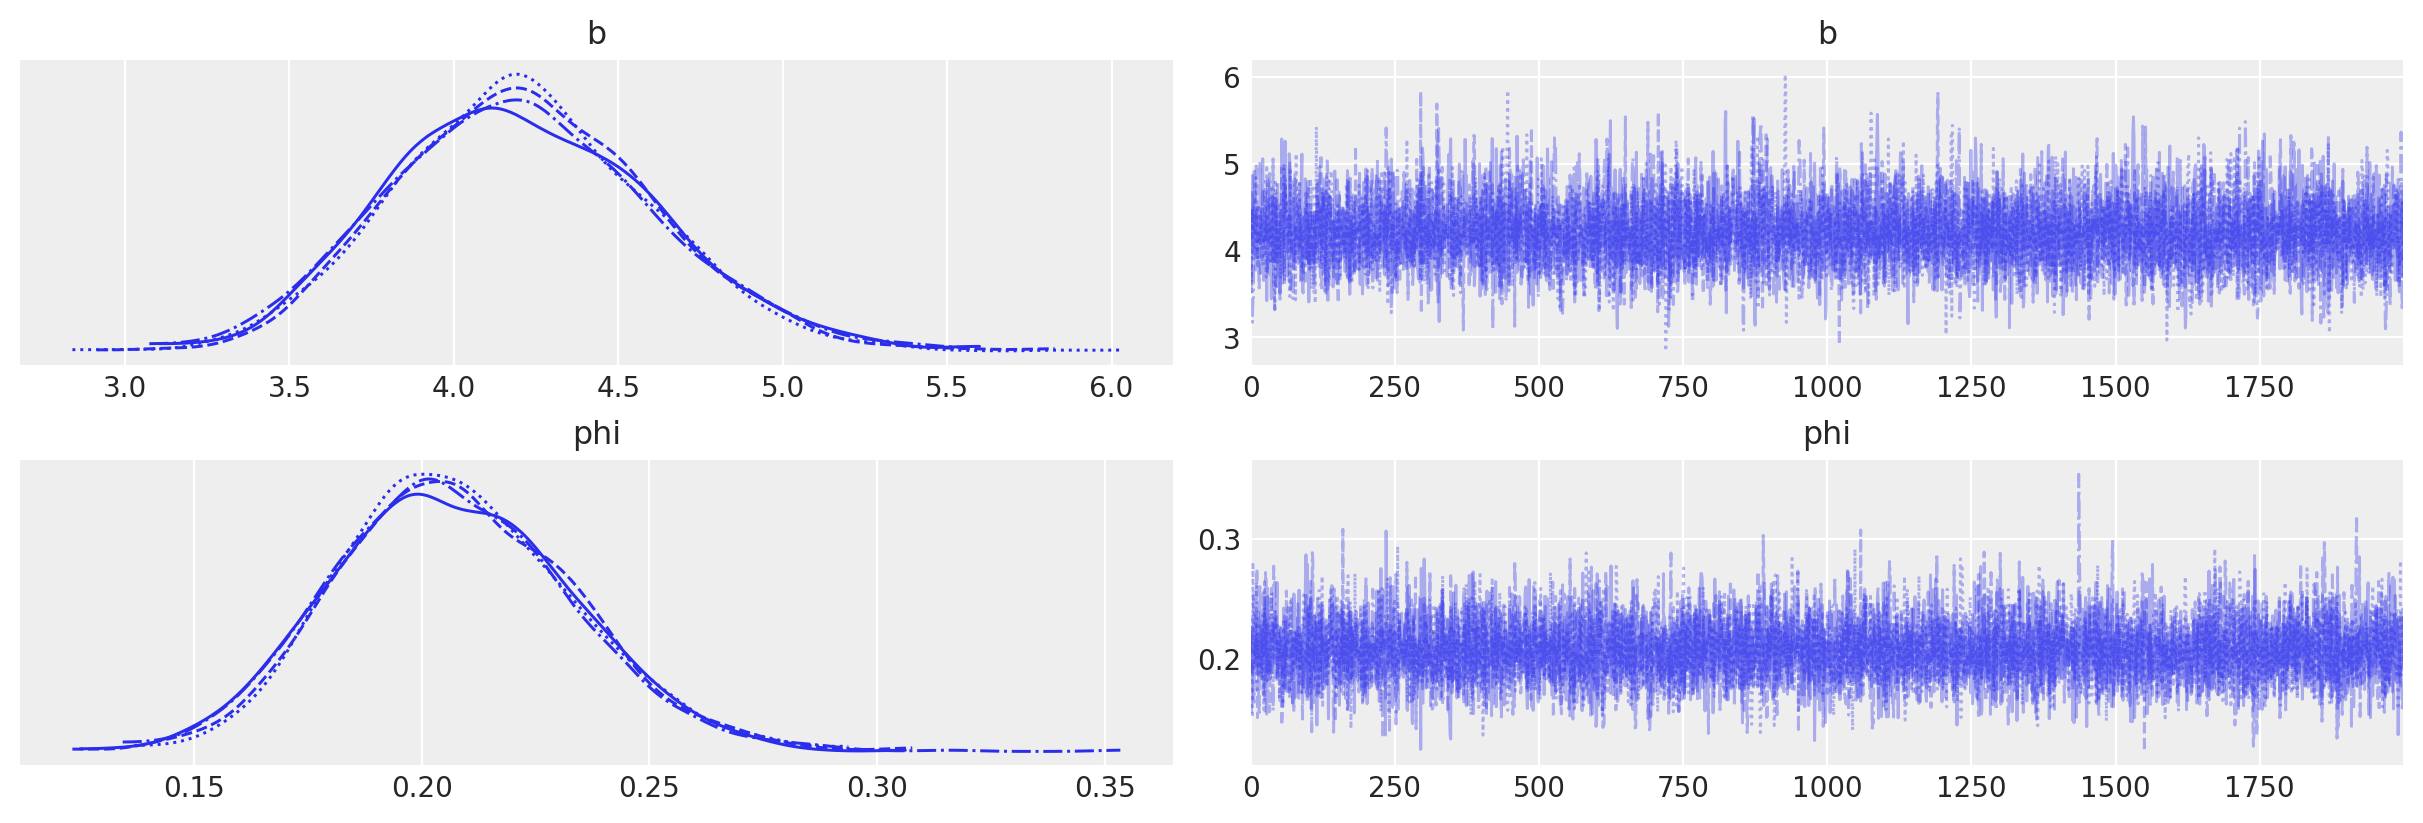

In [61]:
with pm.Model() as mh1_8:
    b = pm.Exponential("b", 1, shape=1)
    phi = pm.Exponential("phi", 0.5)
    
    F = pm.MutableData("F",value=df.femininity_norm)
    D = pm.MutableData("D",value=df.damage_norm_unit)
    
    lam = at.exp(b * F)

    T = pm.NegativeBinomial("deaths", lam, phi, observed=df.deaths)

    trace_mh1_8 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)

# store pareto-k values for plot:
k_mh1_8 = az.loo(trace_mh1_8, pointwise=True).pareto_k.values

az.plot_trace(trace_mh1_8, compact=True);

Pareto LOO still has good k values

<Axes: xlabel='femininity', ylabel='deaths'>

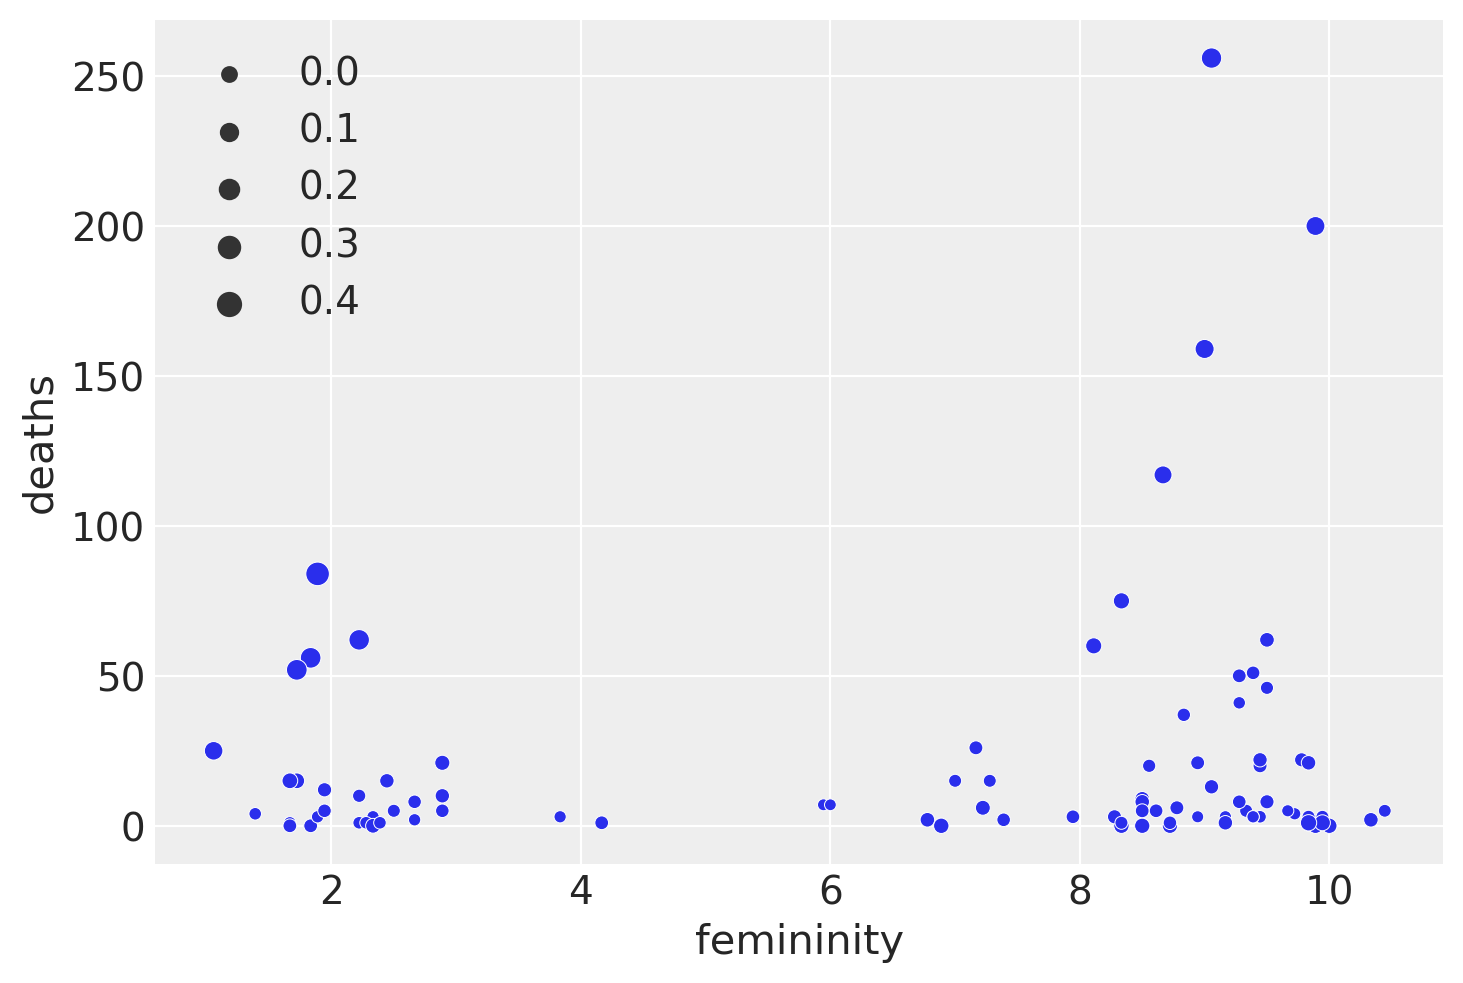

In [63]:
import seaborn as sns
sns.scatterplot(x=df.femininity, y=df.deaths, size=k_mh1_8 )

Note how the coefficient b is higher using the linearly interpolated damages instead of the logarithm. This makes sense because of the range of the values (0,1). The Gamma distribution parameter has not changed instead.

In [64]:
az.summary(trace_mh1_8, var_names=["b","phi"], round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
b[0]  4.21  0.40      3.55       4.80        0.0      0.0   7414.03   5189.83   
phi   0.21  0.03      0.17       0.25        0.0      0.0   7994.45   5414.66   

      r_hat  
b[0]    1.0  
phi     1.0

In [65]:
az.summary(trace_mh1_6, var_names=["b","phi"], round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
b[0]  0.52  0.05      0.45       0.60        0.0      0.0   7128.56   5508.30   
phi   0.24  0.03      0.19       0.29        0.0      0.0   6981.80   5518.51   

      r_hat  
b[0]    1.0  
phi     1.0

In [66]:
with mh1_8:
    retro_mh1_8 = pm.sample_posterior_predictive(trace_mh1_8, var_names=["deaths"])[
        "posterior_predictive"]["deaths"]

Sampling: [deaths]


Retrodiction Does not seem to go very well

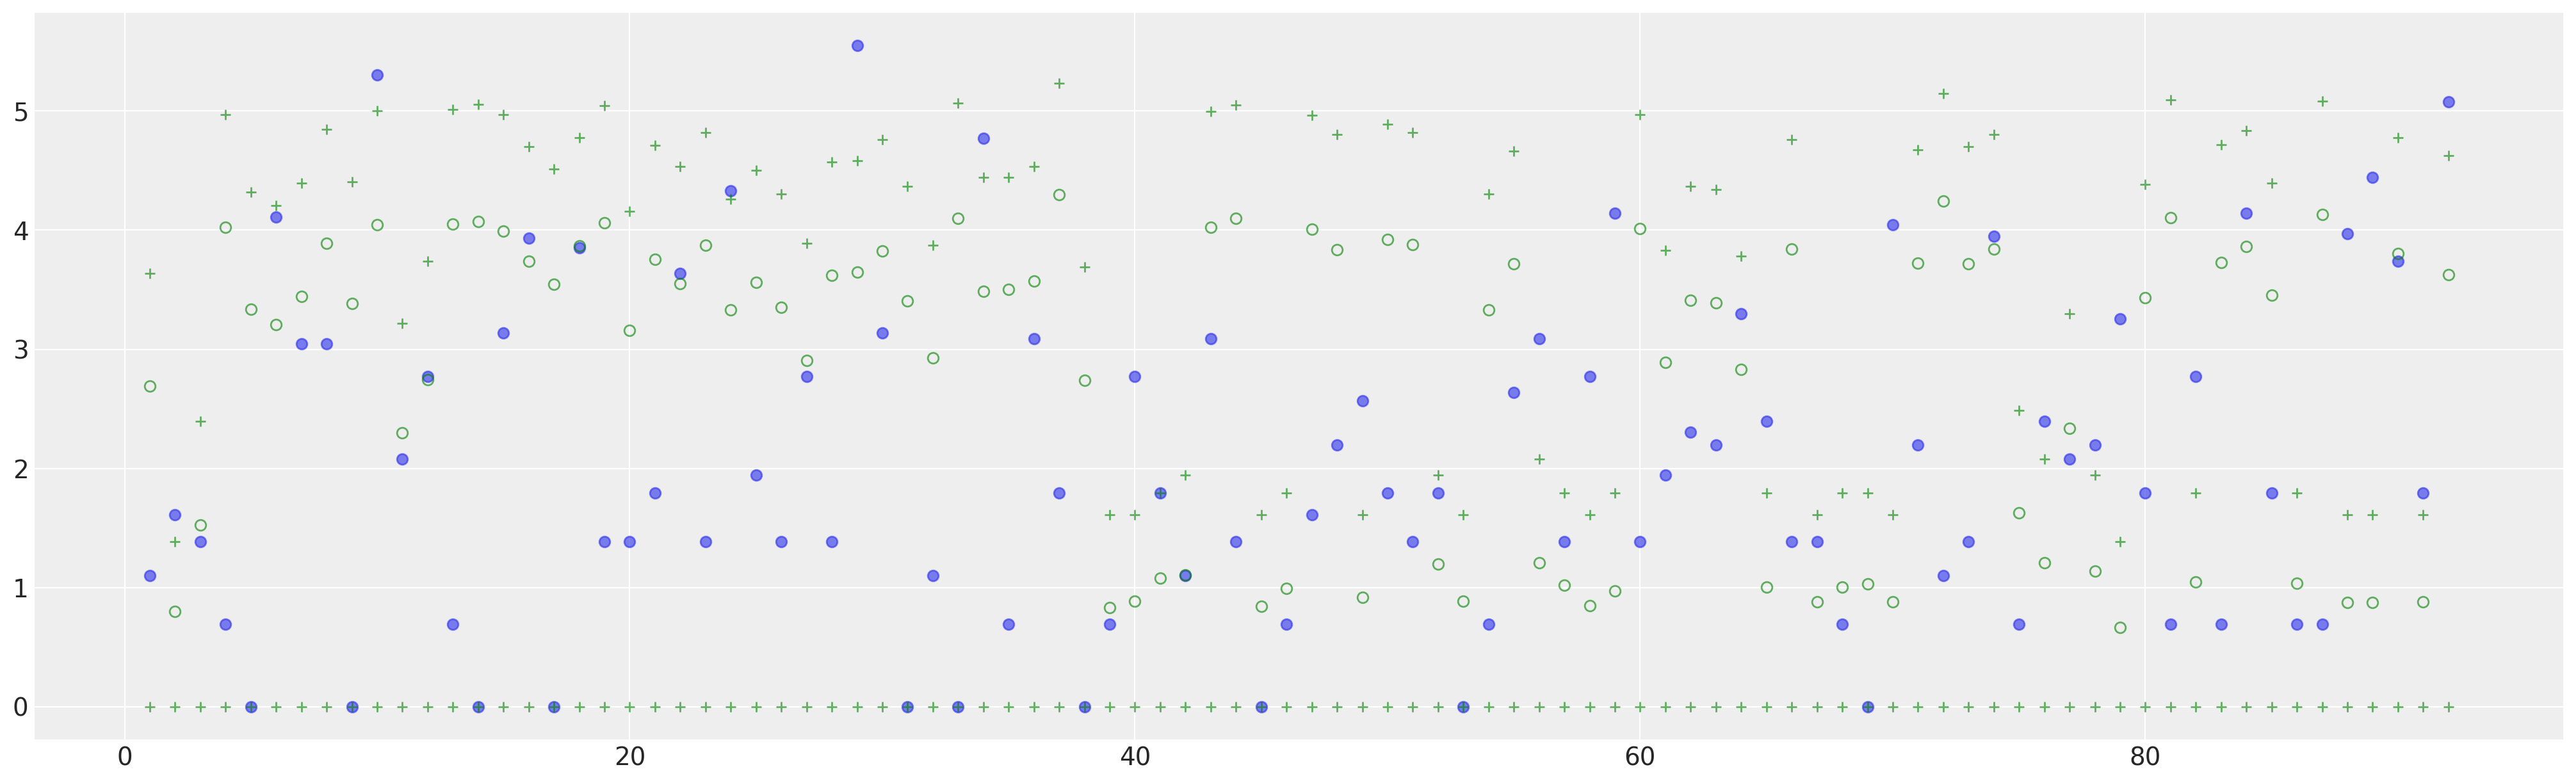

In [67]:
plt.figure(figsize=(20,6))

plt.plot(range(1,df.shape[0]+1), np.log1p( df.deaths ), "C0o", ms=6, alpha=0.6)

plt.plot(
    range(1,df.shape[0]+1),
    np.log1p( retro_mh1_8.mean(["chain", "draw"]) ),
    "go",
    fillstyle="none",
    ms=6,
    alpha=0.6,
)

plt.plot(np.concatenate((range(1,df.shape[0]+1), range(1,df.shape[0]+1))), 
         np.log1p( np.ravel( az.hdi(retro_mh1_8).to_array().T ) ), "g+", ms=6, alpha=0.6)

We can look at retrodiction relative errors for the two models. It is immediate to see that, problematic retrodictions are such for both models, but the one using linear damages has much larger relative errors

Text(0.5, 1.0, 'Relative errors of retrodictions')

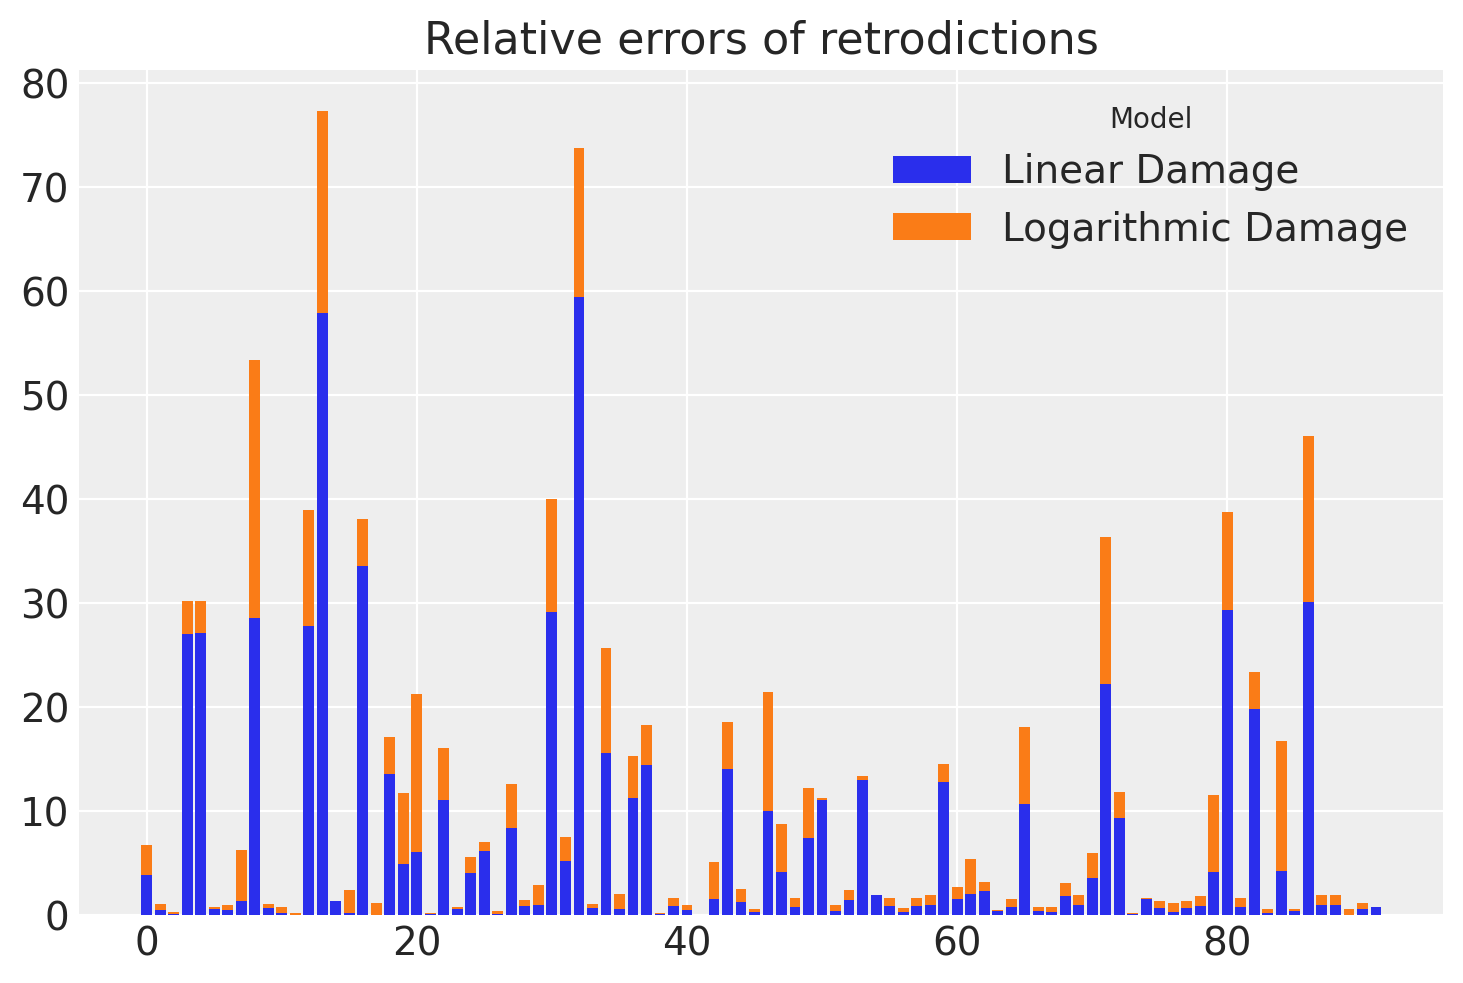

In [111]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)

err_lin = np.abs( df.deaths - retro_mh1_8.mean(["chain", "draw"]) ) / ( df.deaths + 1 )
err_log = np.abs( df.deaths - retro_mh1_6.mean(["chain", "draw"]) ) / ( df.deaths + 1 )

ax.bar(x=np.arange(len(err_lin)), height=err_lin)
ax.bar(x=np.arange(len(err_log)), height=err_log, bottom=err_lin)

ax.legend(title='Model', loc='upper right', labels=['Linear Damage', 'Logarithmic Damage'])
ax.set_title('Relative errors of retrodictions')

The PSIS comparison is also completely in favour of the model using the logarithm

In [113]:
az.compare({"Linear damage": trace_mh1_8, "Logarithmic damage": trace_mh1_6})

rank    elpd_loo     p_loo  elpd_diff  weight         se  \
Logarithmic damage     0 -395.273365  4.875653   0.000000     1.0  27.357337   
Linear damage          1 -405.063078  3.948551   9.789713     0.0  26.158014   

                         dse  warning scale  
Logarithmic damage  0.000000    False   log  
Linear damage       2.490813    False   log